In [240]:
import pandas as pd
import numpy as np
from datetime import datetime
import re
import os # Import os for file path operations
# import googlemaps # No longer used as we're using a Kaggle dataset, not the API
# import time # No longer used
import shutil
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, skew, kurtosis
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from prophet import Prophet
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
import joblib
from tensorflow.keras.models import save_model
import warnings

warnings.warn("This is a warning", UserWarning)
#from scipy.spatial import KDTree # Import KDTree for spatial indexing

/tmp/ipykernel_24541/1705820302.py:25: UserWarning: This is a warning
  warnings.warn("This is a warning", UserWarning)


In [241]:
# === SETUP ===
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

# Load dataset from Excel
file_path = "../data/raw/global-superstore.xlsx"
df_orders = pd.read_excel(file_path, sheet_name="Orders")
df_returns = pd.read_excel(file_path, sheet_name="Returns")
df_people = pd.read_excel(file_path, sheet_name="People") # Load the 'People' sheet

print("Orders:")
print(df_orders.info())
print("\nReturns:")
print(df_returns.info())
print("\nPeople:")
print(df_people.info())

Orders:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Row ID          51290 non-null  int64         
 1   Order ID        51290 non-null  object        
 2   Order Date      51290 non-null  datetime64[ns]
 3   Ship Date       51290 non-null  datetime64[ns]
 4   Ship Mode       51290 non-null  object        
 5   Customer ID     51290 non-null  object        
 6   Customer Name   51290 non-null  object        
 7   Segment         51290 non-null  object        
 8   City            51290 non-null  object        
 9   State           51290 non-null  object        
 10  Country         51290 non-null  object        
 11  Postal Code     9994 non-null   float64       
 12  Market          51290 non-null  object        
 13  Region          51290 non-null  object        
 14  Product ID      51290 non-null  object        

In [242]:
print("\nSample orders data:")
print(df_orders.head())
print("\nSample returns data:")
print(df_returns.head())
print("\nSample people data:")
print(df_people.head())


Sample orders data:
   Row ID         Order ID Order Date  Ship Date     Ship Mode Customer ID  \
0   32298   CA-2012-124891 2012-07-31 2012-07-31      Same Day    RH-19495   
1   26341    IN-2013-77878 2013-02-05 2013-02-07  Second Class    JR-16210   
2   25330    IN-2013-71249 2013-10-17 2013-10-18   First Class    CR-12730   
3   13524  ES-2013-1579342 2013-01-28 2013-01-30   First Class    KM-16375   
4   47221     SG-2013-4320 2013-11-05 2013-11-06      Same Day     RH-9495   

      Customer Name      Segment           City            State  \
0       Rick Hansen     Consumer  New York City         New York   
1     Justin Ritter    Corporate     Wollongong  New South Wales   
2      Craig Reiter     Consumer       Brisbane       Queensland   
3  Katherine Murray  Home Office         Berlin           Berlin   
4       Rick Hansen     Consumer          Dakar            Dakar   

         Country  Postal Code  Market   Region        Product ID    Category  \
0  United States     

In [243]:
print("Missing values in orders:\n", df_orders.isnull().sum())
print("\nMissing values in returns:\n", df_returns.isnull().sum())
print("\nMissing values in people:\n", df_people.isnull().sum())
print("Duplicate rows in orders:", df_orders.duplicated().sum())
print("Duplicate rows in returns:", df_returns.duplicated().sum())
print("Duplicate rows in people:", df_people.duplicated().sum())

Missing values in orders:
 Row ID                0
Order ID              0
Order Date            0
Ship Date             0
Ship Mode             0
Customer ID           0
Customer Name         0
Segment               0
City                  0
State                 0
Country               0
Postal Code       41296
Market                0
Region                0
Product ID            0
Category              0
Sub-Category          0
Product Name          0
Sales                 0
Quantity              0
Discount              0
Profit                0
Shipping Cost         0
Order Priority        0
dtype: int64

Missing values in returns:
 Returned    0
Order ID    0
Market      0
dtype: int64

Missing values in people:
 Person    0
Region    0
dtype: int64
Duplicate rows in orders: 0
Duplicate rows in returns: 0
Duplicate rows in people: 0


In [244]:
df_orders = df_orders.drop(columns=['Postal Code'])

In [245]:
# === MERGE RETURN FLAG ===
df_orders = df_orders.merge(
    df_returns[["Order ID", "Returned"]],
    on="Order ID",
    how="left"
)
df_orders["Returned"] = df_orders["Returned"].fillna("No").astype("category")
print("\nDataFrame df_orders after merging Return Flag:")
print(df_orders.head())


DataFrame df_orders after merging Return Flag:
   Row ID         Order ID Order Date  Ship Date     Ship Mode Customer ID  \
0   32298   CA-2012-124891 2012-07-31 2012-07-31      Same Day    RH-19495   
1   26341    IN-2013-77878 2013-02-05 2013-02-07  Second Class    JR-16210   
2   25330    IN-2013-71249 2013-10-17 2013-10-18   First Class    CR-12730   
3   13524  ES-2013-1579342 2013-01-28 2013-01-30   First Class    KM-16375   
4   47221     SG-2013-4320 2013-11-05 2013-11-06      Same Day     RH-9495   

      Customer Name      Segment           City            State  \
0       Rick Hansen     Consumer  New York City         New York   
1     Justin Ritter    Corporate     Wollongong  New South Wales   
2      Craig Reiter     Consumer       Brisbane       Queensland   
3  Katherine Murray  Home Office         Berlin           Berlin   
4       Rick Hansen     Consumer          Dakar            Dakar   

         Country  Market   Region        Product ID    Category Sub-Catego

In [246]:
print("\nCurrent columns in df_orders:", df_orders.columns.tolist())


Current columns in df_orders: ['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'City', 'State', 'Country', 'Market', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit', 'Shipping Cost', 'Order Priority', 'Returned']


In [247]:
print("Missing values in orders:\n", df_orders.isnull().sum())

Missing values in orders:
 Row ID            0
Order ID          0
Order Date        0
Ship Date         0
Ship Mode         0
Customer ID       0
Customer Name     0
Segment           0
City              0
State             0
Country           0
Market            0
Region            0
Product ID        0
Category          0
Sub-Category      0
Product Name      0
Sales             0
Quantity          0
Discount          0
Profit            0
Shipping Cost     0
Order Priority    0
Returned          0
dtype: int64


In [248]:
# --- FEATURE ENGINEERING ---
df_orders["Shipping Duration"] = (df_orders["Ship Date"] - df_orders["Order Date"]).dt.days
df_orders["Order Year"] = df_orders["Order Date"].dt.year
df_orders["Order Month"] = df_orders["Order Date"].dt.month
df_orders['Discount Rate'] = df_orders['Discount'] / (1 - df_orders['Discount'])
df_orders['Sales Category'] = pd.cut(df_orders['Sales'],
                                    bins=[0, 100, 500, 1000, 100000],
                                    labels=['Low', 'Medium', 'High', 'Very High'])

print("\nDataFrame df_orders after Feature Engineering:")
print(df_orders.head())


DataFrame df_orders after Feature Engineering:
   Row ID         Order ID Order Date  Ship Date     Ship Mode Customer ID  \
0   32298   CA-2012-124891 2012-07-31 2012-07-31      Same Day    RH-19495   
1   26341    IN-2013-77878 2013-02-05 2013-02-07  Second Class    JR-16210   
2   25330    IN-2013-71249 2013-10-17 2013-10-18   First Class    CR-12730   
3   13524  ES-2013-1579342 2013-01-28 2013-01-30   First Class    KM-16375   
4   47221     SG-2013-4320 2013-11-05 2013-11-06      Same Day     RH-9495   

      Customer Name      Segment           City            State  \
0       Rick Hansen     Consumer  New York City         New York   
1     Justin Ritter    Corporate     Wollongong  New South Wales   
2      Craig Reiter     Consumer       Brisbane       Queensland   
3  Katherine Murray  Home Office         Berlin           Berlin   
4       Rick Hansen     Consumer          Dakar            Dakar   

         Country  Market   Region        Product ID    Category Sub-Catego

In [249]:
# === DATA DESCRIPTION ===
print(df_orders.describe(include="all"))

              Row ID        Order ID                     Order Date  \
count   51295.000000           51295                          51295   
unique           NaN           25035                            NaN   
top              NaN  CA-2014-100111                            NaN   
freq             NaN              14                            NaN   
mean    25644.896598             NaN  2013-05-11 22:30:30.213471232   
min         1.000000             NaN            2011-01-01 00:00:00   
25%     12821.500000             NaN            2012-06-19 00:00:00   
50%     25645.000000             NaN            2013-07-08 00:00:00   
75%     38466.500000             NaN            2014-05-22 00:00:00   
max     51290.000000             NaN            2014-12-31 00:00:00   
std     14806.333027             NaN                            NaN   

                            Ship Date       Ship Mode Customer ID  \
count                           51295           51295       51295   
unique   

In [250]:
#numerical_variables = df.select_dtypes(exclude='O')
numerical_variables = df_orders.select_dtypes(include=['number'])
categorical_variables = df_orders.select_dtypes(include='O') #(Python) objects

numerical_variables.head()

numerical_variables.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51295 entries, 0 to 51294
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Row ID             51295 non-null  int64  
 1   Sales              51295 non-null  float64
 2   Quantity           51295 non-null  int64  
 3   Discount           51295 non-null  float64
 4   Profit             51295 non-null  float64
 5   Shipping Cost      51295 non-null  float64
 6   Shipping Duration  51295 non-null  int64  
 7   Order Year         51295 non-null  int32  
 8   Order Month        51295 non-null  int32  
 9   Discount Rate      51295 non-null  float64
dtypes: float64(5), int32(2), int64(3)
memory usage: 3.5 MB


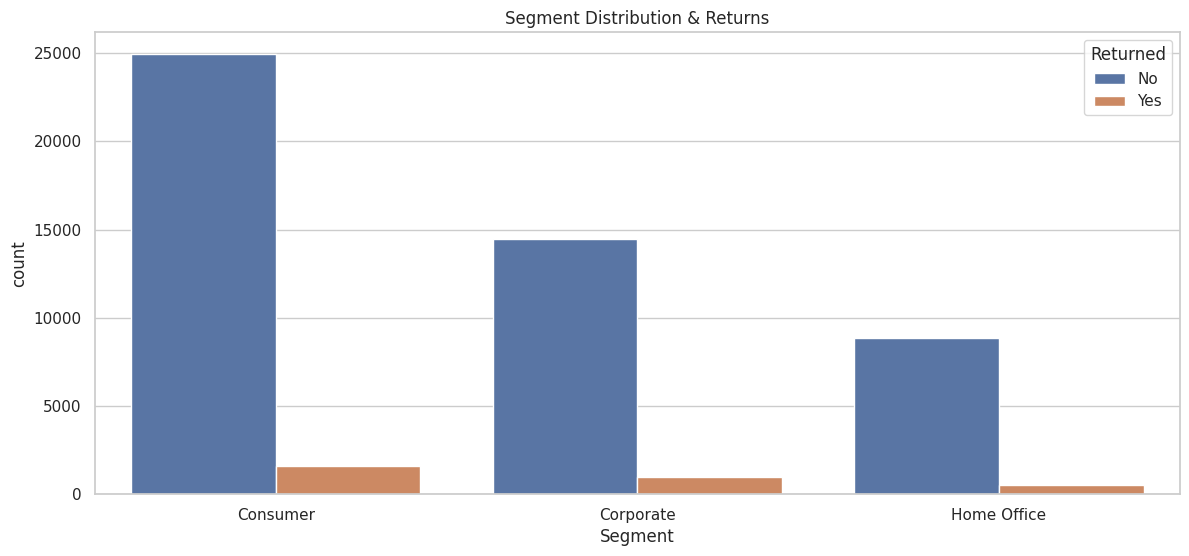

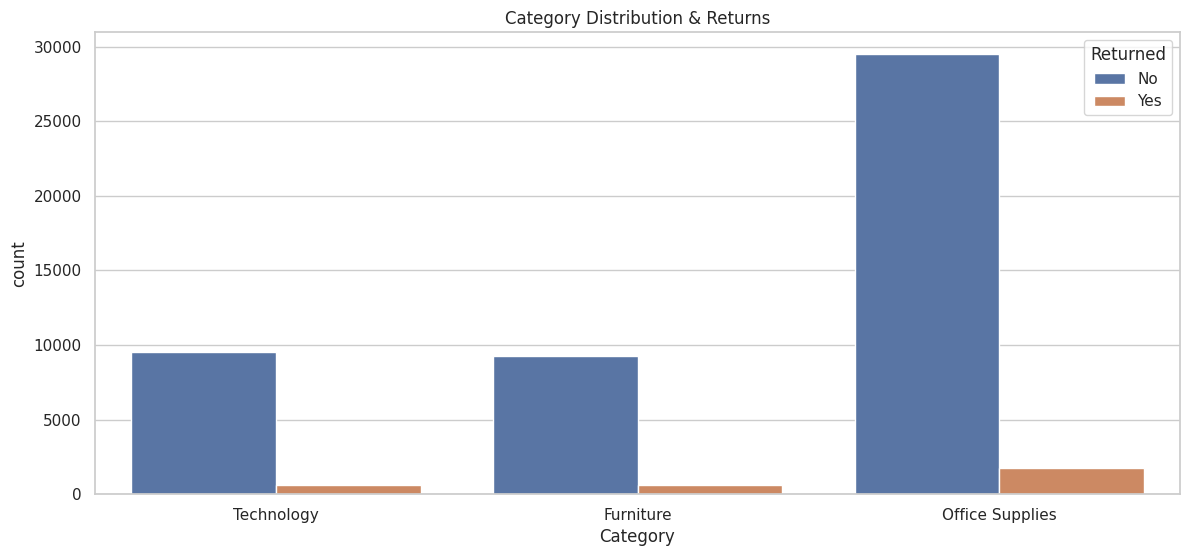

In [251]:
# === CATEGORY DISTRIBUTION ===
plt.figure(figsize=(14,6))
sns.countplot(data=df_orders, x="Segment", hue="Returned")
plt.title("Segment Distribution & Returns")
plt.show()

plt.figure(figsize=(14,6))
sns.countplot(data=df_orders, x="Category", hue="Returned")
plt.title("Category Distribution & Returns")
plt.show()


[INFO] --- Additional Step: Deeper Analysis of Categorical Variables ---

Proportion of Returns per Segment:
Segment      Returned
Consumer     No          94.027149
             Yes          5.972851
Corporate    No          93.706656
             Yes          6.293344
Home Office  No          94.650118
             Yes          5.349882
Name: proportion, dtype: float64


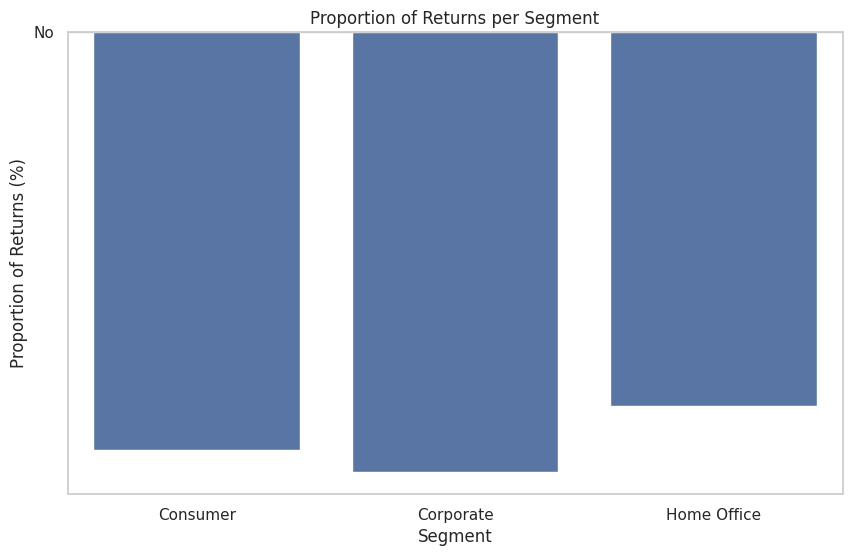

In [252]:
print("\n[INFO] --- Additional Step: Deeper Analysis of Categorical Variables ---")
# Proportion of returns in each segment
print("\nProportion of Returns per Segment:")
print(df_orders.groupby('Segment')['Returned'].value_counts(normalize=True) * 100)

# Visualize proportion of returns per segment (optional)
plt.figure(figsize=(10, 6))
sns.barplot(data=df_orders, x='Segment', y='Returned', errorbar=None)
plt.title('Proportion of Returns per Segment')
plt.ylabel('Proportion of Returns (%)')
plt.show()


Proportion of Returns per Category:
Category         Returned
Furniture        No          93.530424
                 Yes          6.469576
Office Supplies  No          94.276579
                 Yes          5.723421
Technology       No          93.828256
                 Yes          6.171744
Name: proportion, dtype: float64


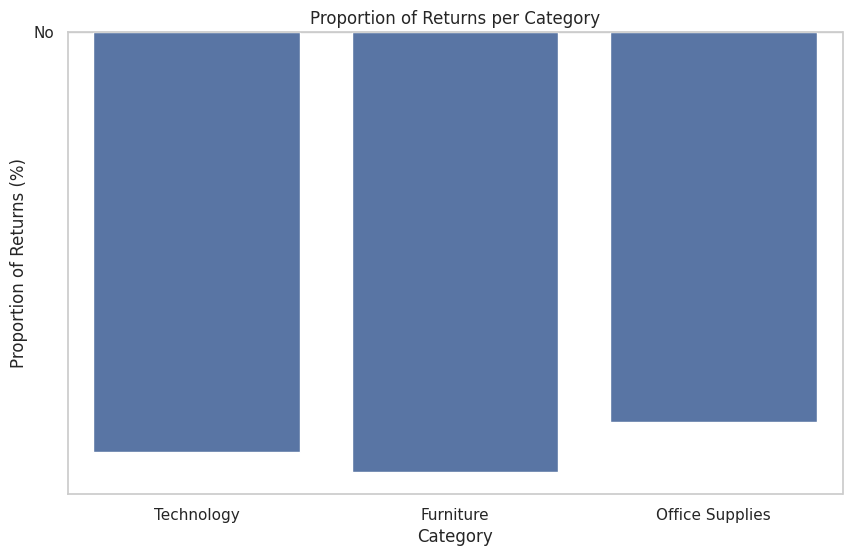


[INFO] --- Done with Categorical Variable Analysis ---


In [253]:
# Proportion of returns in each category
print("\nProportion of Returns per Category:")
print(df_orders.groupby('Category')['Returned'].value_counts(normalize=True) * 100)

# Visualize the proportion of returns per category (optional)
plt.figure(figsize=(10, 6))
sns.barplot(data=df_orders, x='Category', y='Returned', errorbar=None)
plt.title('Proportion of Returns per Category')
plt.ylabel('Proportion of Returns (%)')
plt.show()
print("\n[INFO] --- Done with Categorical Variable Analysis ---")

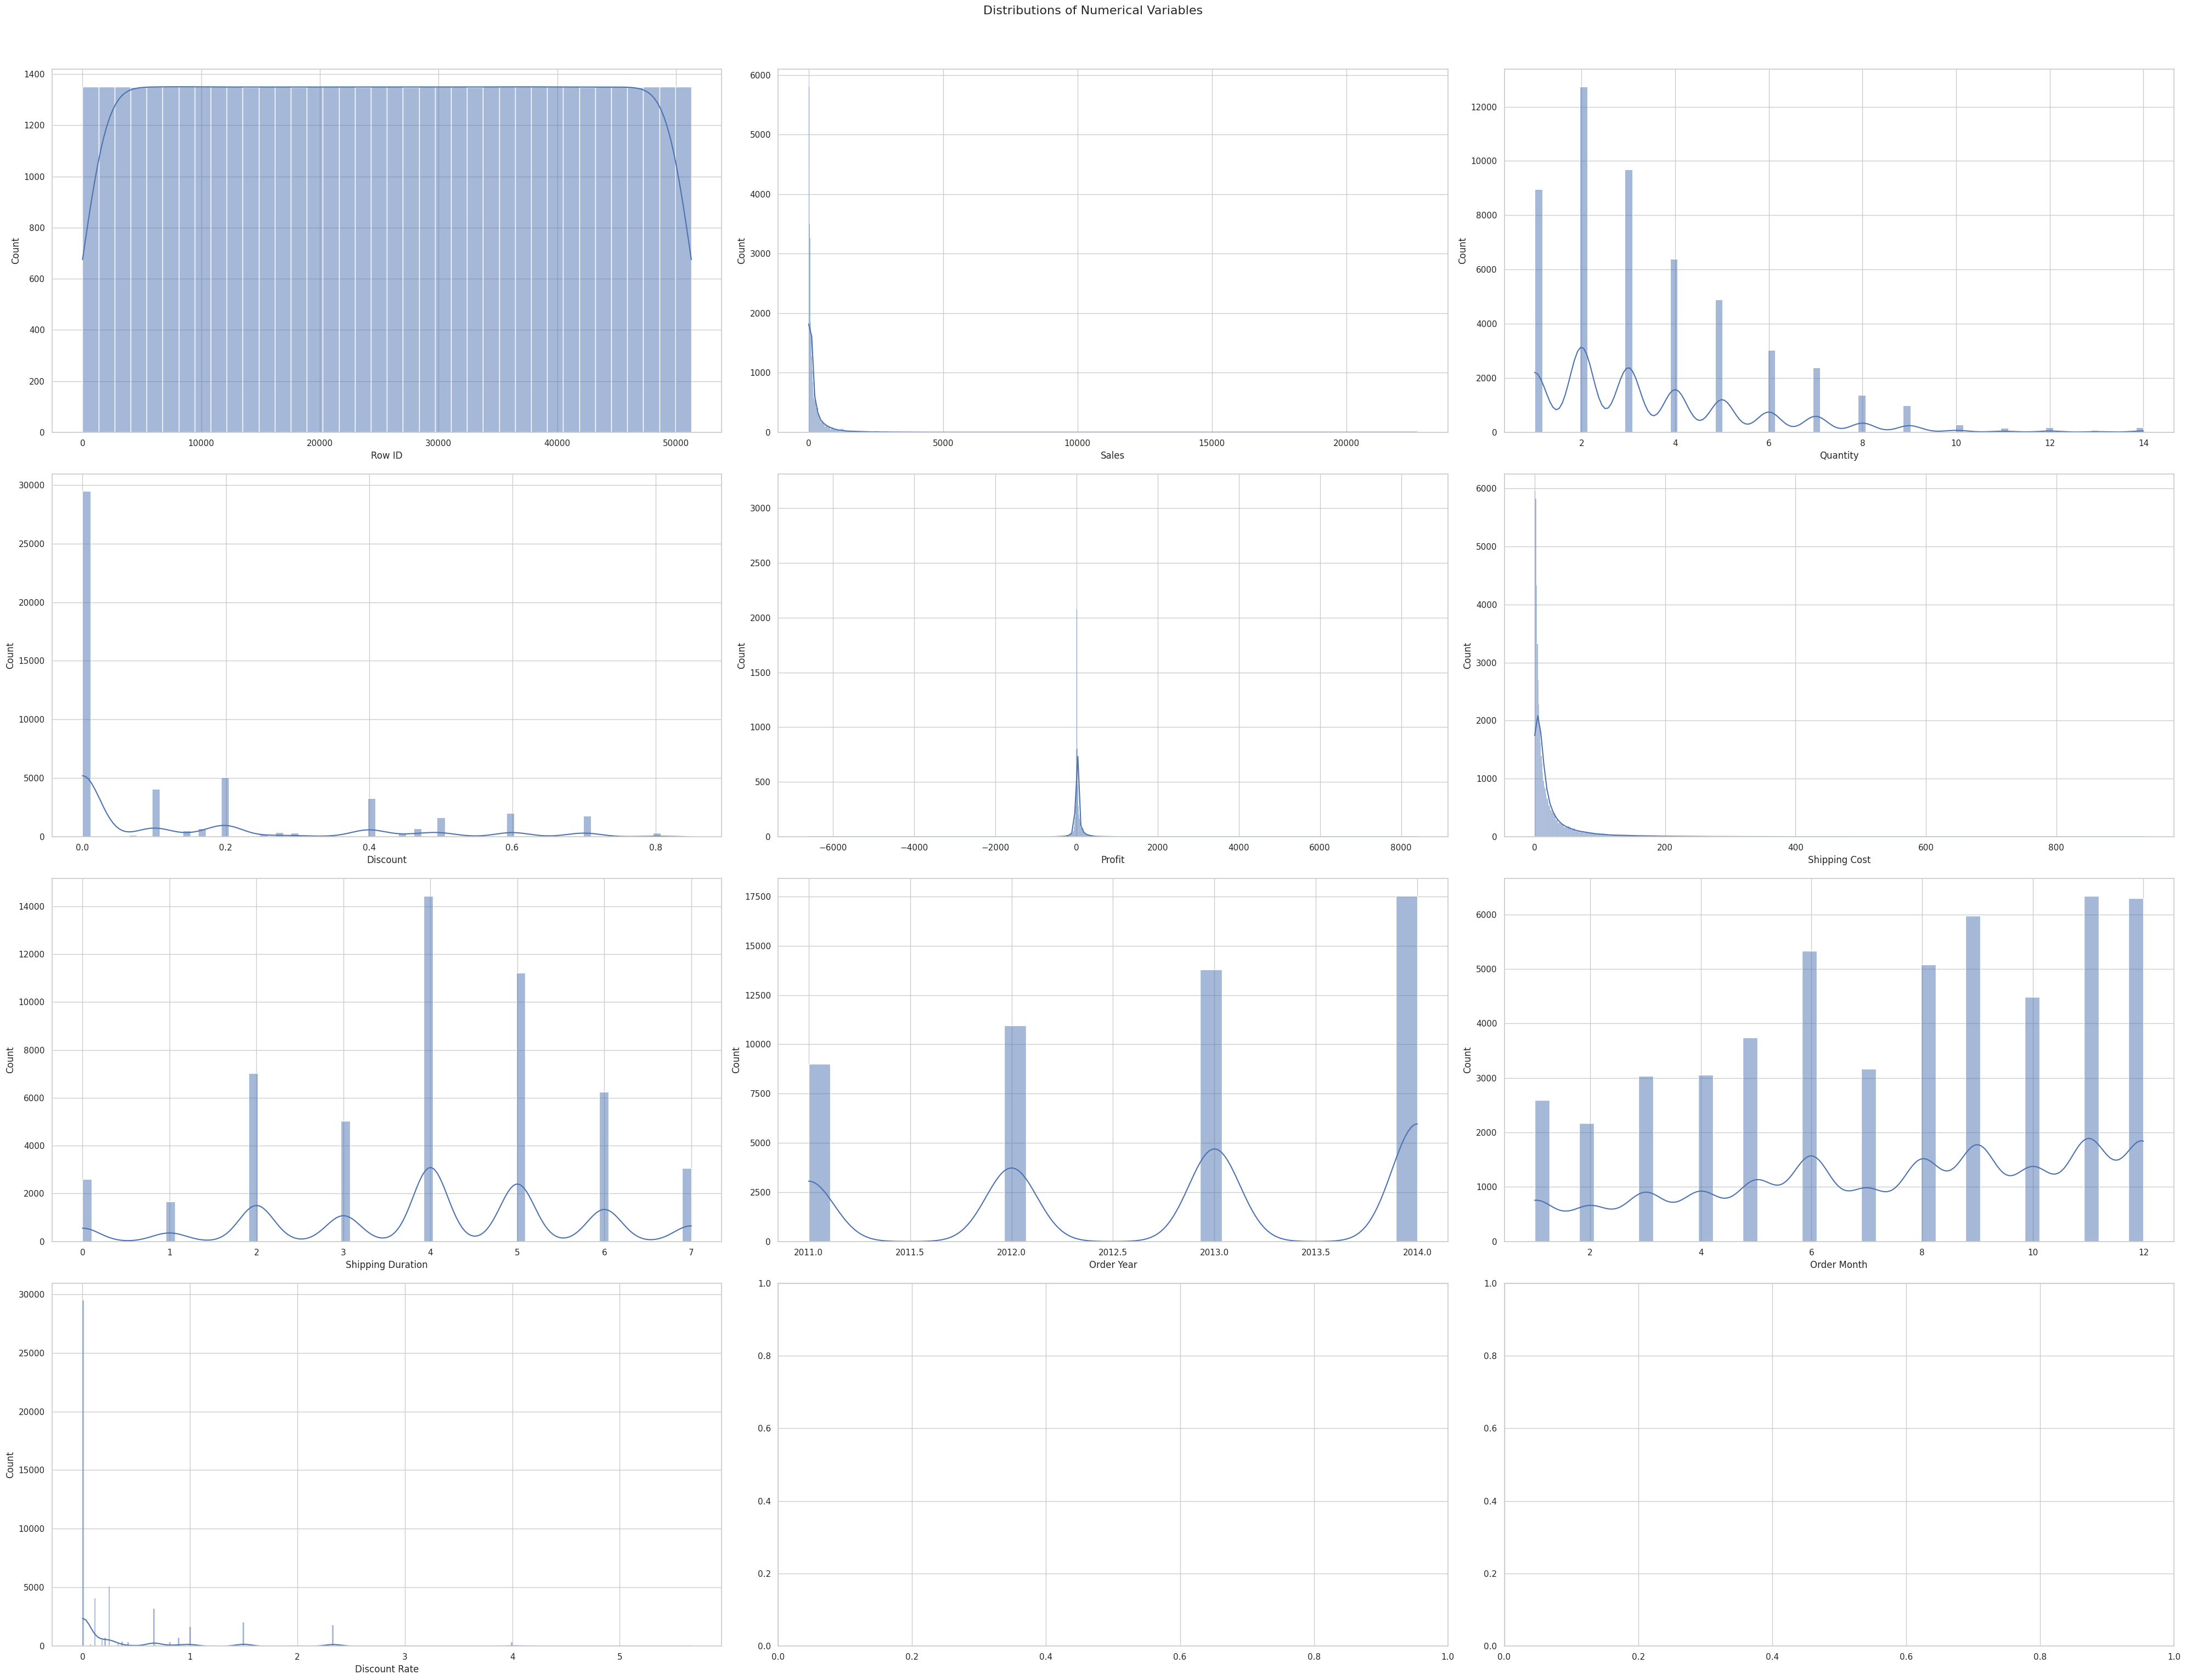

In [254]:
# === NUMERIC DISTRIBUTION ===
fig, ax = plt.subplots(4, 3, figsize=(40, 30))
for var, subplot in zip(numerical_variables, ax.flatten()): 
    sns.histplot(df_orders[var], ax=subplot, kde=True)
plt.suptitle("Distributions of Numerical Variables", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()
#plt.savefig('distribution.png')


[INFO] --- Additional Step: Numerical Variable Correlation Analysis ---


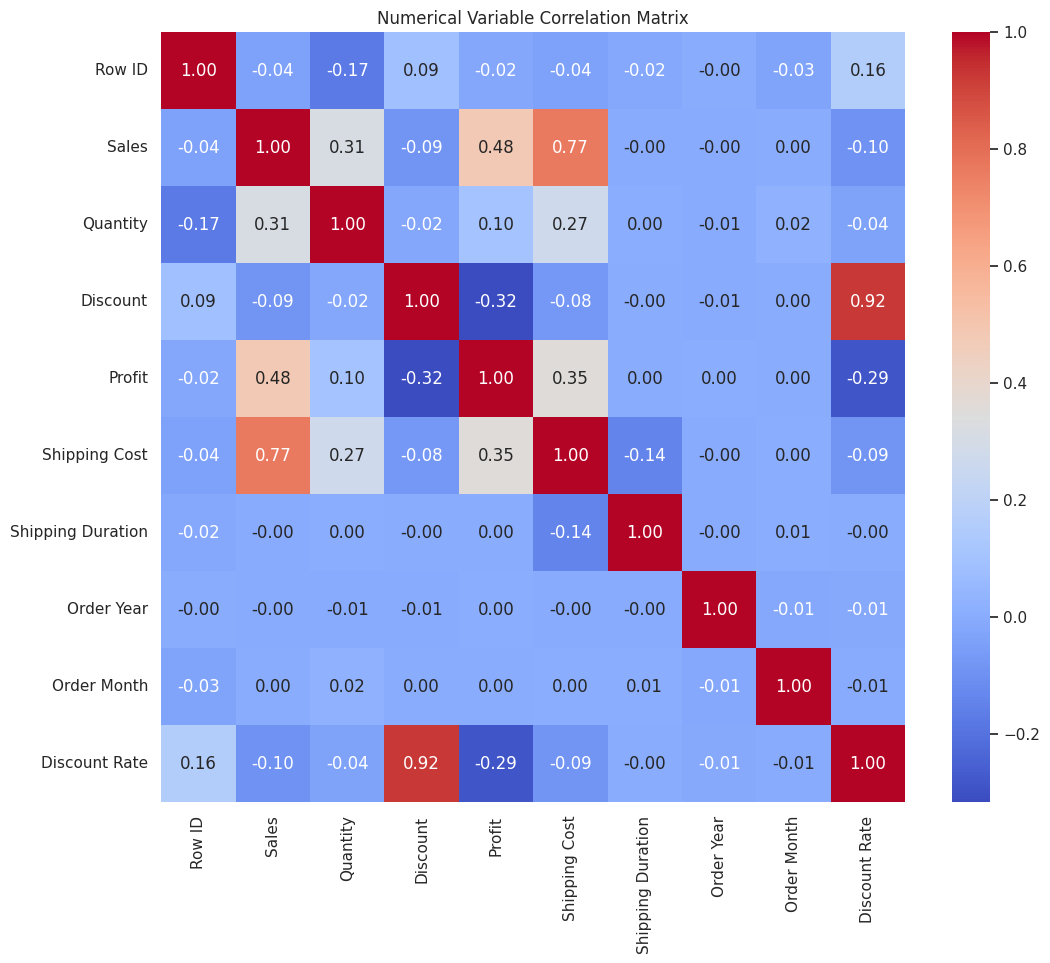


[INFO] --- Done with Numerical Correlation Analysis ---


In [255]:
print("\n[INFO] --- Additional Step: Numerical Variable Correlation Analysis ---")
# Select only numeric columns
numerical_df = df_orders.select_dtypes(include=np.number)

# Calculate the correlation matrix
correlation_matrix = numerical_df.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Numerical Variable Correlation Matrix')
plt.show()
print("\n[INFO] --- Done with Numerical Correlation Analysis ---")


[INFO] --- Additional Steps: More Detailed Distribution of Numerical Data ---

Descriptive Statistics for Column 'Row ID':
Skewness: 4.0259120178238335e-05
Kurtosis: -1.2000689118687533


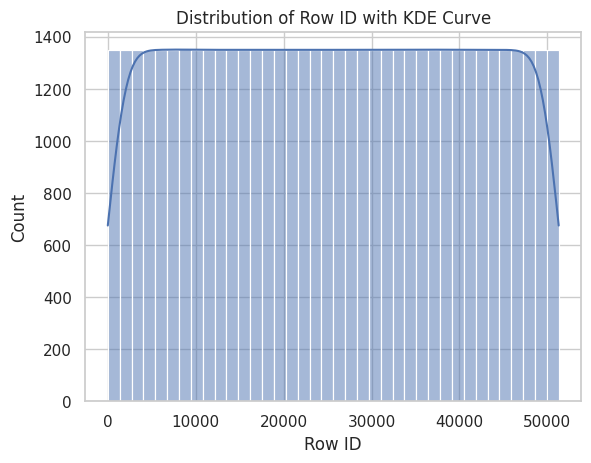


Descriptive Statistics for Column 'Sales':
Skewness: 8.138162702588636
Kurtosis: 176.72815742528115


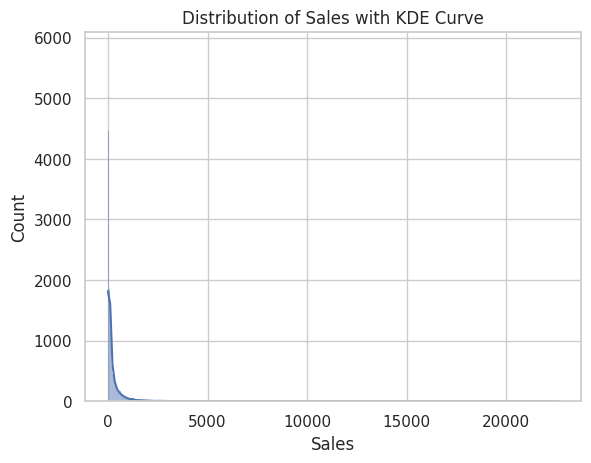


Descriptive Statistics for Column 'Quantity':
Skewness: 1.3603395448831181
Kurtosis: 2.2756459844453847


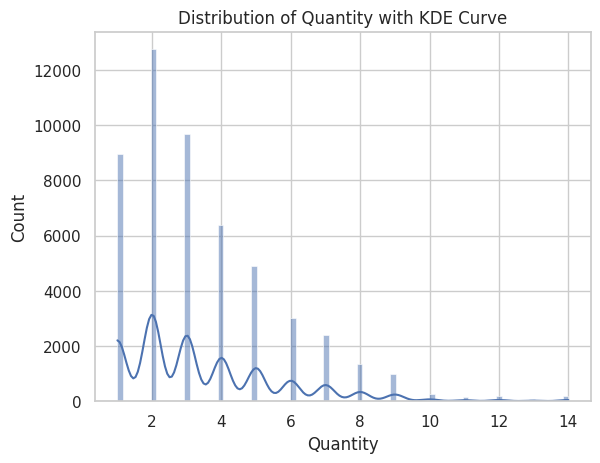


Descriptive Statistics for Column 'Discount':
Skewness: 1.3877768088322413
Kurtosis: 0.7167617581879027


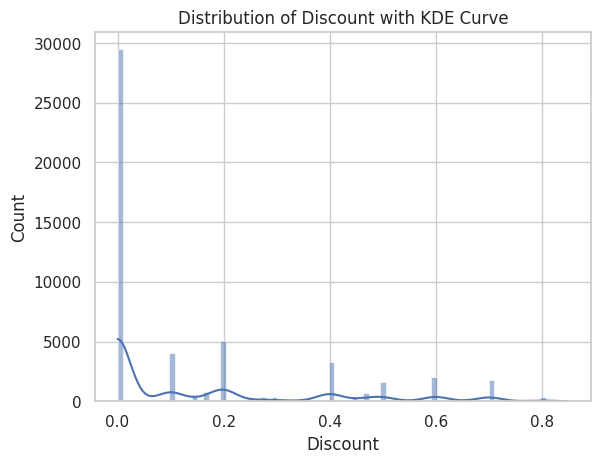


Descriptive Statistics for Column 'Profit':
Skewness: 4.157209754171642
Kurtosis: 291.40392173360675


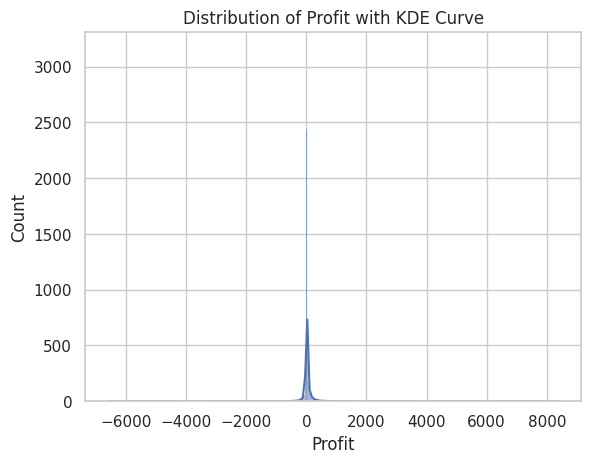


Descriptive Statistics for Column 'Shipping Cost':
Skewness: 5.863312123478918
Kurtosis: 50.01969313588512


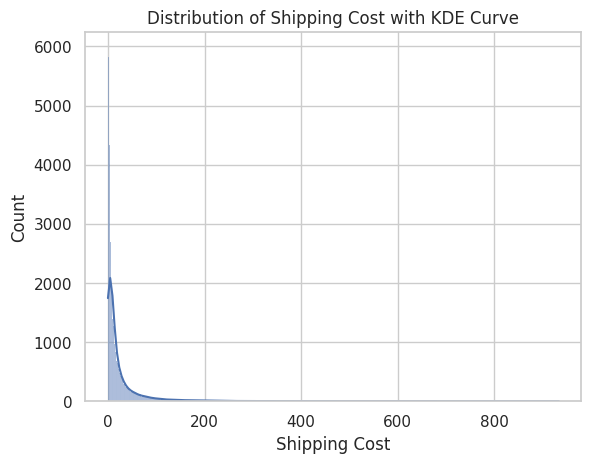


Descriptive Statistics for Column 'Shipping Duration':
Skewness: -0.4320666523121287
Kurtosis: -0.24983232396262833


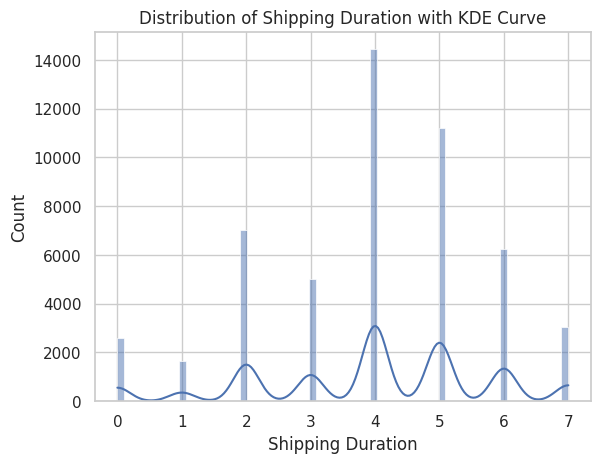


Descriptive Statistics for Column 'Order Year':
Skewness: -0.34465077679194556
Kurtosis: -1.2219881726148505


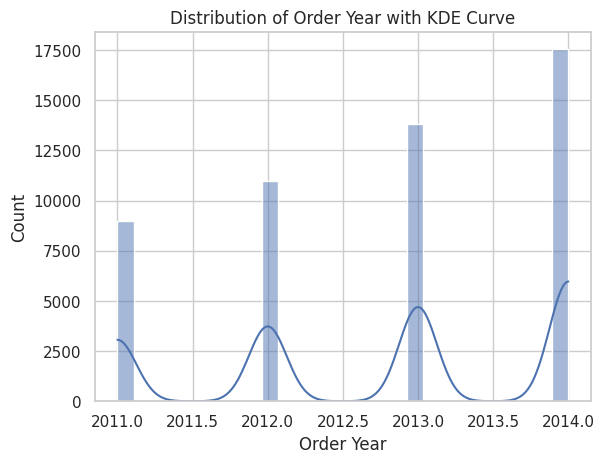


Descriptive Statistics for Column 'Order Month':
Skewness: -0.357950687881835
Kurtosis: -0.97785777584116


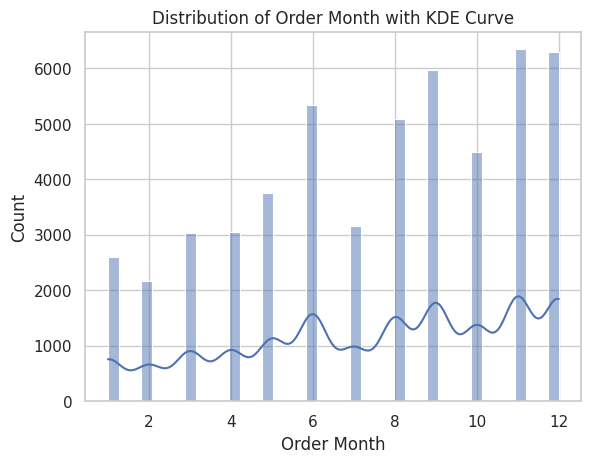


Descriptive Statistics for Column 'Discount Rate':
Skewness: 2.952428843125306
Kurtosis: 10.330286023752342


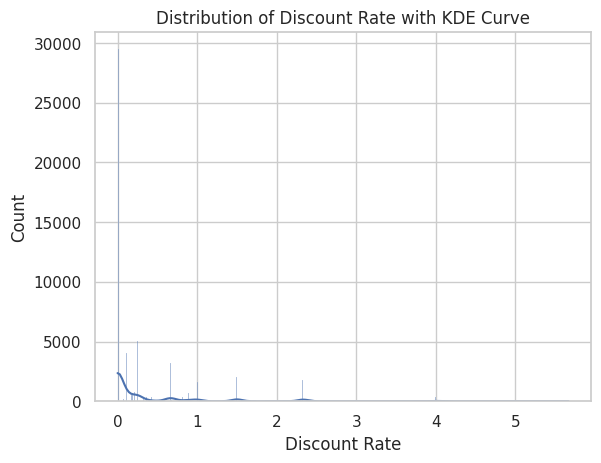


[INFO] --- Done with Numerical Distribution Analysis ---


In [256]:
print("\n[INFO] --- Additional Steps: More Detailed Distribution of Numerical Data ---")
numerical_cols = numerical_df.columns

for col in numerical_cols:
    print(f"\nDescriptive Statistics for Column '{col}':")
    print(f"Skewness: {skew(df_orders[col])}")
    print(f"Kurtosis: {kurtosis(df_orders[col])}")
    sns.histplot(df_orders[col], kde=True)
    plt.title(f'Distribution of {col} with KDE Curve')
    plt.show()
print("\n[INFO] --- Done with Numerical Distribution Analysis ---")


[INFO] --- Additional Steps: Outlier Analysis and Handling ---


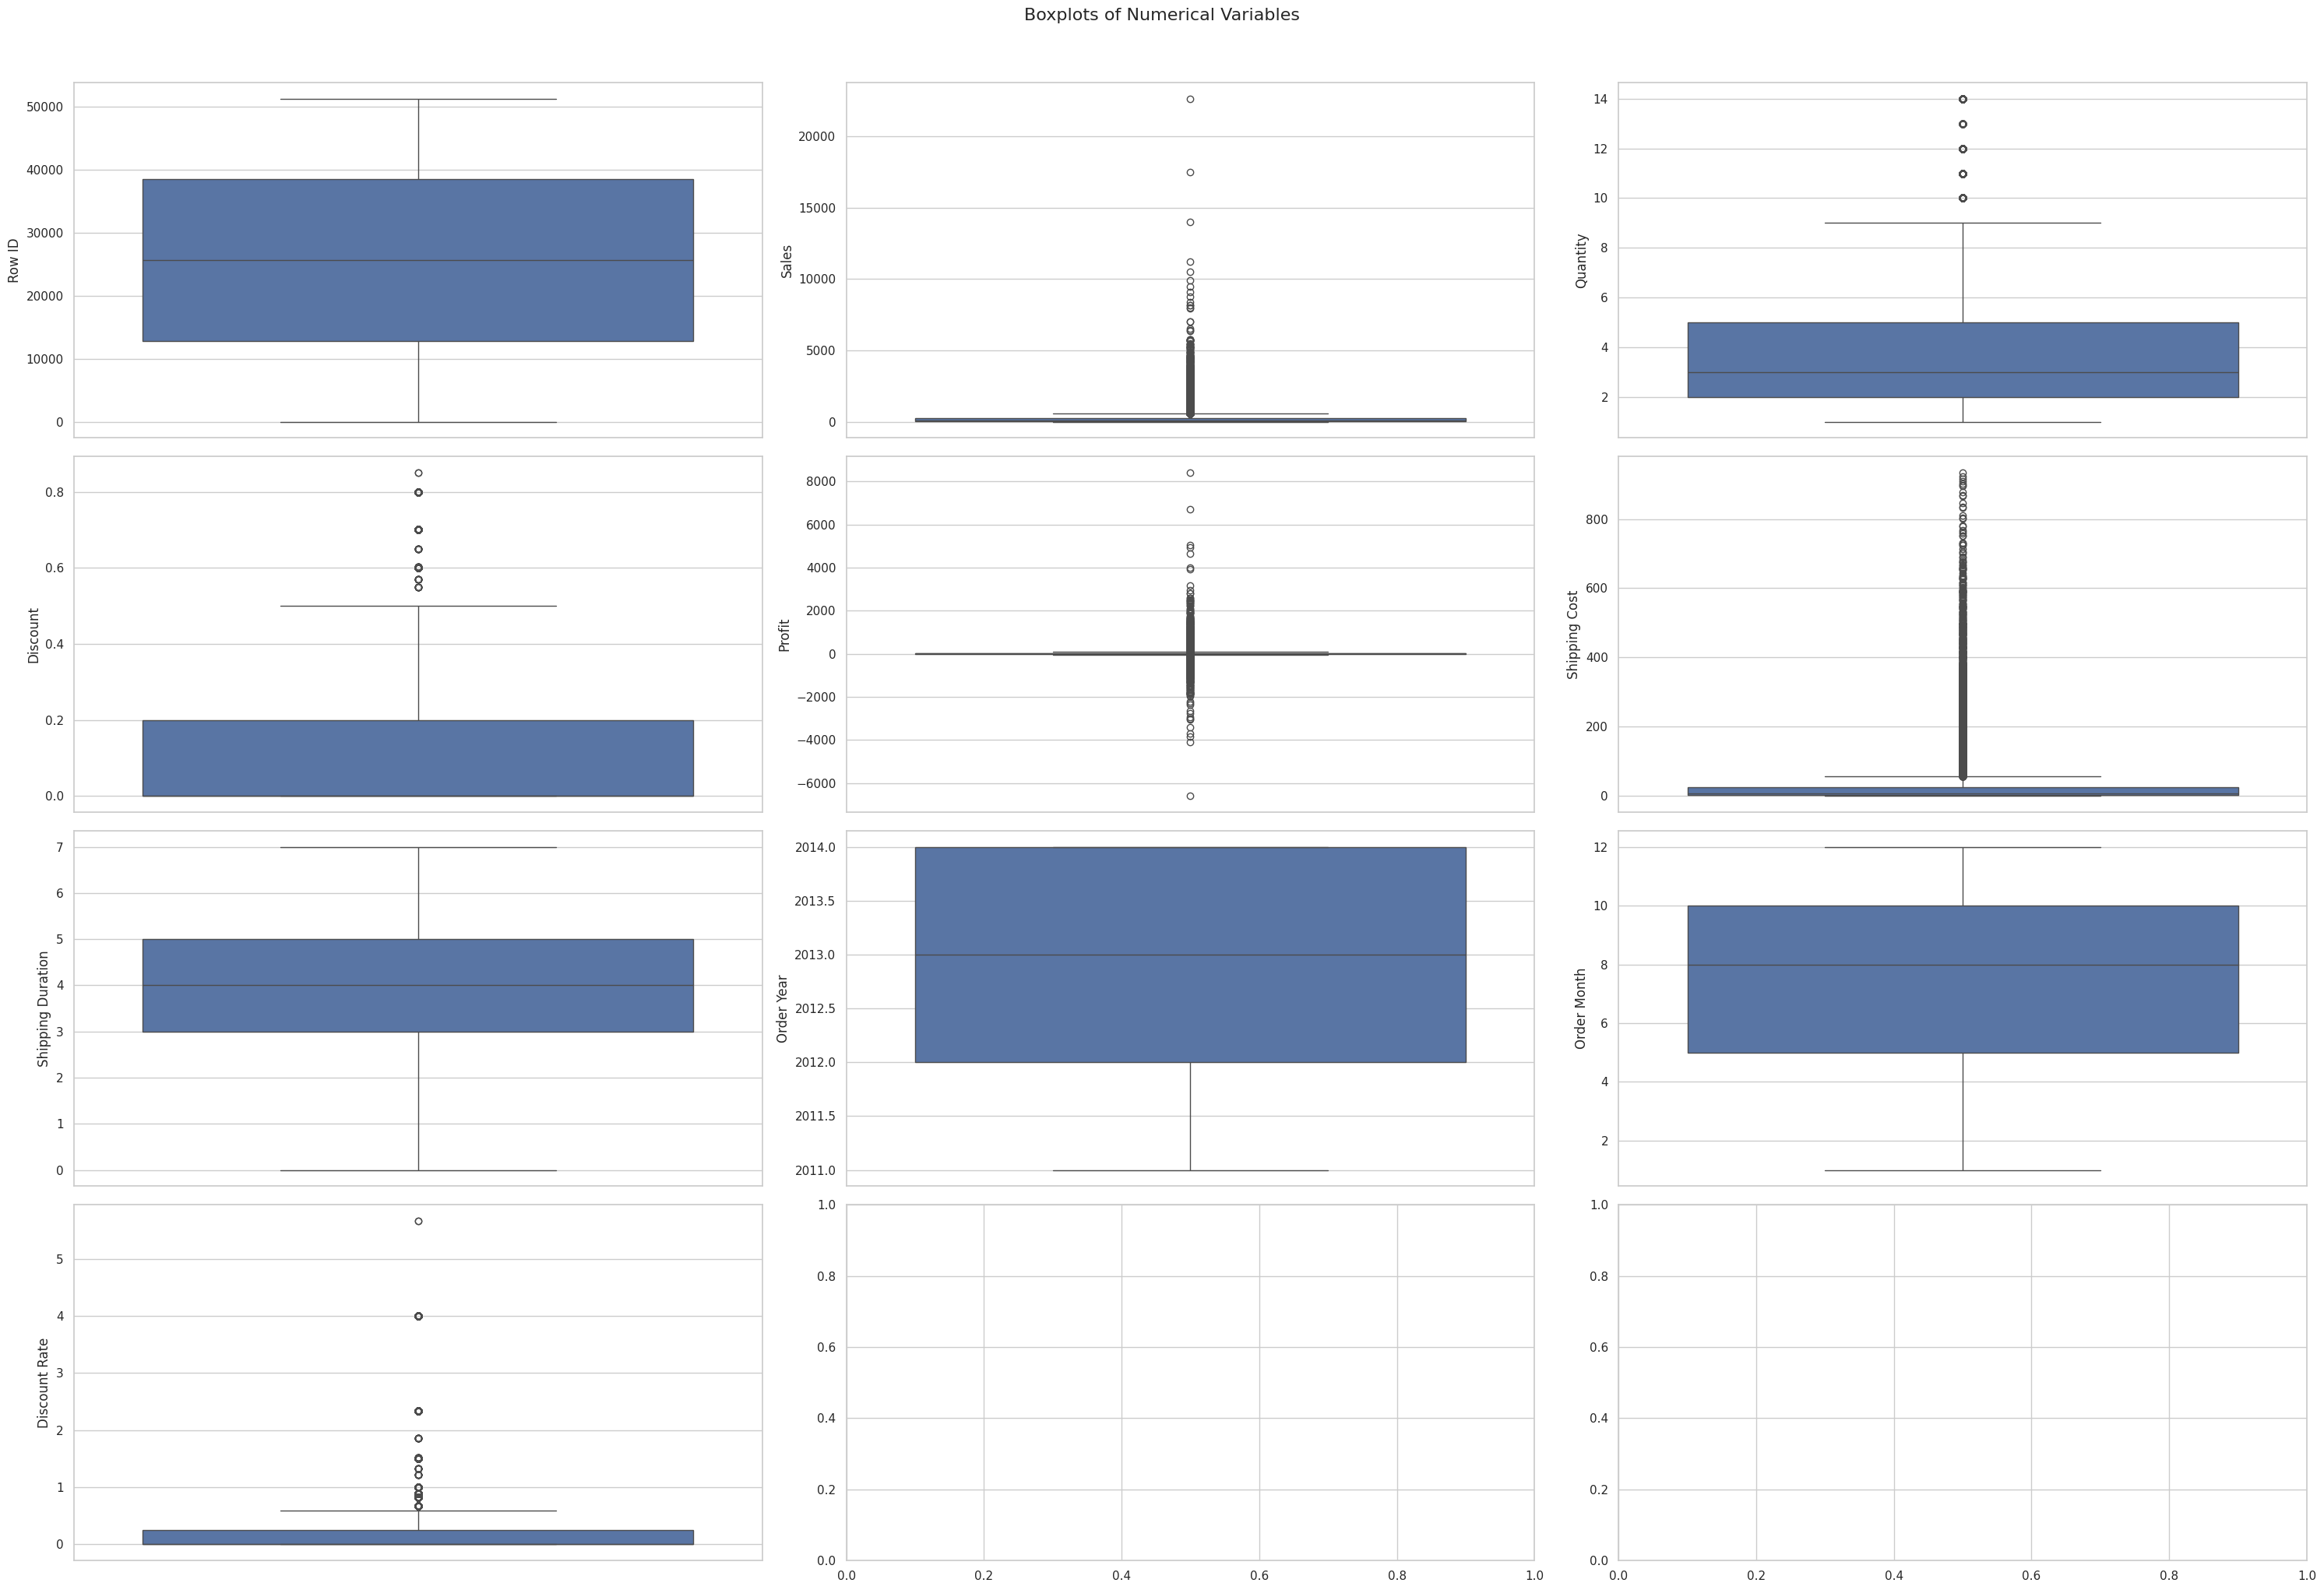

In [257]:
# === OUTLIER DETECTION: PROFIT ===
print("\n[INFO] --- Additional Steps: Outlier Analysis and Handling ---")

# Plot the boxplots for the numerical columns
fig, ax = plt.subplots(4, 3, figsize=(30,20))
for var, subplot in zip(numerical_variables, ax.flatten()): 
    sns.boxplot(df_orders[var], ax=subplot)
plt.suptitle("Boxplots of Numerical Variables", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()
#plt.savefig('outliers.png')

In [258]:
# Example of outlier analysis for column 'Profit' (you can repeat for other columns)
print("\n[OUTLIER ANALYSIS FOR COLUMN 'Profit']")
Q1_profit = df_orders['Profit'].quantile(0.25)
Q3_profit = df_orders['Profit'].quantile(0.75)
IQR_profit = Q3_profit - Q1_profit
lower_bound_profit = Q1_profit - 1.5 * IQR_profit
upper_bound_profit = Q3_profit + 1.5 * IQR_profit

print(f"First Quartile (Q1) Profit: {Q1_profit}")
print(f"Third Quartile (Q3) Profit: {Q3_profit}")
print(f"Interquartile Range (IQR) Profit: {IQR_profit}")
print(f"Lower Bound of Outlier Profit: {lower_bound_profit}")
print(f"Upper Bound Outlier Profit: {upper_bound_profit}")

# Number of outliers below the lower bound and above the upper bound
outliers_lower_profit = df_orders[df_orders['Profit'] < lower_bound_profit]
outliers_upper_profit = df_orders[df_orders['Profit'] > upper_bound_profit]
print(f"\nNumber of Outliers Below the Lower Profit Boundary: {len(outliers_lower_profit)}")
print(f"\nNumber of Outliers Above the Upper Profit Boundary: {len(outliers_upper_profit)}")

# Option to filter DataFrame without outliers in 'Profit' column (Uncomment if you want to use it)
# df_orders_no_profit_outliers = df_orders[(df_orders['Profit'] >= lower_bound_profit) & (df_orders['Profit'] <= upper_bound_profit)].copy()
# print(f"\nNumber of rows before handling Profit outliers: {len(df_orders)}")
# print(f"Number of rows after handling Profit outliers: {len(df_orders_no_profit_outliers)}")
# df_orders = df_orders_no_profit_outliers # If you decide to use the filtered DataFrame

print("\n[INFO] --- Done with Outlier Analysis and Handling ---")


[OUTLIER ANALYSIS FOR COLUMN 'Profit']
First Quartile (Q1) Profit: 0.0
Third Quartile (Q3) Profit: 36.81
Interquartile Range (IQR) Profit: 36.81
Lower Bound of Outlier Profit: -55.215
Upper Bound Outlier Profit: 92.025

Number of Outliers Below the Lower Profit Boundary: 3526

Number of Outliers Above the Upper Profit Boundary: 6230

[INFO] --- Done with Outlier Analysis and Handling ---


In [259]:
# === RETURN RATE ===
return_rate = df_orders["Returned"].value_counts(normalize=True) * 100
print("Return Rate (%):\n", return_rate)

print("\n[INFO] --- Additional Steps: Integration with 'people' Data ---")
# Merge df_orders with df_people based on 'Region'
df_orders_merged = pd.merge(df_orders, df_people, on='Region', how='left')
print("\nSample data df_orders after merging with df_people:")
print(df_orders_merged.head())

# To continue the analysis with this data, you can replace df_orders with df_orders_merged
# df_orders = df_orders_merged
print("\n[INFO] --- Done with 'people' Data Integration ---")

Return Rate (%):
 Returned
No     94.044254
Yes     5.955746
Name: proportion, dtype: float64

[INFO] --- Additional Steps: Integration with 'people' Data ---

Sample data df_orders after merging with df_people:
   Row ID         Order ID Order Date  Ship Date     Ship Mode Customer ID  \
0   32298   CA-2012-124891 2012-07-31 2012-07-31      Same Day    RH-19495   
1   26341    IN-2013-77878 2013-02-05 2013-02-07  Second Class    JR-16210   
2   25330    IN-2013-71249 2013-10-17 2013-10-18   First Class    CR-12730   
3   13524  ES-2013-1579342 2013-01-28 2013-01-30   First Class    KM-16375   
4   47221     SG-2013-4320 2013-11-05 2013-11-06      Same Day     RH-9495   

      Customer Name      Segment           City            State  \
0       Rick Hansen     Consumer  New York City         New York   
1     Justin Ritter    Corporate     Wollongong  New South Wales   
2      Craig Reiter     Consumer       Brisbane       Queensland   
3  Katherine Murray  Home Office         Berlin

In [260]:
# === SAVE RESULTS ===
df_orders.to_csv("../data/processed/processed_orders.csv", index=False)
print("[INFO] Dataset is ready and saved in ../data/processed/processed_orders.csv")

[INFO] Dataset is ready and saved in ../data/processed/processed_orders.csv


---

## Handling Outlier per Model

In [261]:
# Assumption: df_orders is your clean DataFrame after initial preprocessing

# 1. Handling Outliers for Time Series (Prophet)
df_orders_ts = df_orders.copy()

# Identify and impute outliers in 'Sales' and 'Profit' columns for time series
# (Simple example, you may use more sophisticated methods)
sales_median_ts = df_orders_ts['Sales'].median()
profit_median_ts = df_orders_ts['Profit'].median()

sales_q1_ts = df_orders_ts['Sales'].quantile(0.25)
sales_q3_ts = df_orders_ts['Sales'].quantile(0.75)
sales_iqr_ts = sales_q3_ts - sales_q1_ts
sales_lower_bound_ts = sales_q1_ts - 1.5 * sales_iqr_ts
sales_upper_bound_ts = sales_q3_ts + 1.5 * sales_iqr_ts

profit_q1_ts = df_orders_ts['Profit'].quantile(0.25)
profit_q3_ts = df_orders_ts['Profit'].quantile(0.75)
profit_iqr_ts = profit_q3_ts - profit_q1_ts
profit_lower_bound_ts = profit_q1_ts - 1.5 * profit_iqr_ts
profit_upper_bound_ts = profit_q3_ts + 1.5 * profit_iqr_ts

df_orders_ts.loc[df_orders_ts['Sales'] < sales_lower_bound_ts, 'Sales'] = sales_median_ts
df_orders_ts.loc[df_orders_ts['Sales'] > sales_upper_bound_ts, 'Sales'] = sales_median_ts
df_orders_ts.loc[df_orders_ts['Profit'] < profit_lower_bound_ts, 'Profit'] = profit_median_ts
df_orders_ts.loc[df_orders_ts['Profit'] > profit_upper_bound_ts, 'Profit'] = profit_median_ts

print("\n[INFO] Outlier handling completed for Time Series data (df_orders_ts)")


[INFO] Outlier handling completed for Time Series data (df_orders_ts)


In [262]:
# 2. Handling Outliers for Customer Analytics (Masking Approach)
df_orders_ca = df_orders.copy()

# Create a mask for positive Profit values
positive_profit_mask = df_orders_ca['Profit'] > 0

# Initialize the Profit_log column with the original Profit values
df_orders_ca['Profit_log'] = df_orders_ca['Profit'].copy()

# Apply log1p only to positive Profit values ​​using a mask
df_orders_ca.loc[positive_profit_mask, 'Profit_log'] = np.log1p(df_orders_ca.loc[positive_profit_mask, 'Profit'])

# Handle null values ​​in 'Sales' and 'Quantity' with epsilon before log
epsilon = np.finfo(float).eps
df_orders_ca['Sales_log'] = np.log1p(df_orders_ca['Sales'].replace(0, epsilon))
df_orders_ca['Quantity_log'] = np.log1p(df_orders_ca['Quantity'].replace(0, epsilon))

print("\n[INFO] Outlier handling (log transformation for positive Profit - Masking) completed for Customer Analytics data (df_orders_ca)")


[INFO] Outlier handling (log transformation for positive Profit - Masking) completed for Customer Analytics data (df_orders_ca)


In [263]:
# 3. Outlier Handling for Recommender System
df_orders_rs = df_orders.copy()

# For recommender system, outlier handling may differ depending on the features used.

# If we are using purchase amount or rating, we may want to limit the extreme values.

# (Example of limiting value, adjust limit as needed)
if 'Quantity' in df_orders_rs.columns:
    df_orders_rs['Quantity'] = df_orders_rs['Quantity'].clip(upper=50) # Limit the number of purchases per transaction

print("\n[INFO] Outlier handling completed for Recommender System data (df_orders_rs)")


[INFO] Outlier handling completed for Recommender System data (df_orders_rs)


## Time Series with Prophet

22:08:36 - cmdstanpy - INFO - Chain [1] start processing
22:08:36 - cmdstanpy - INFO - Chain [1] done processing


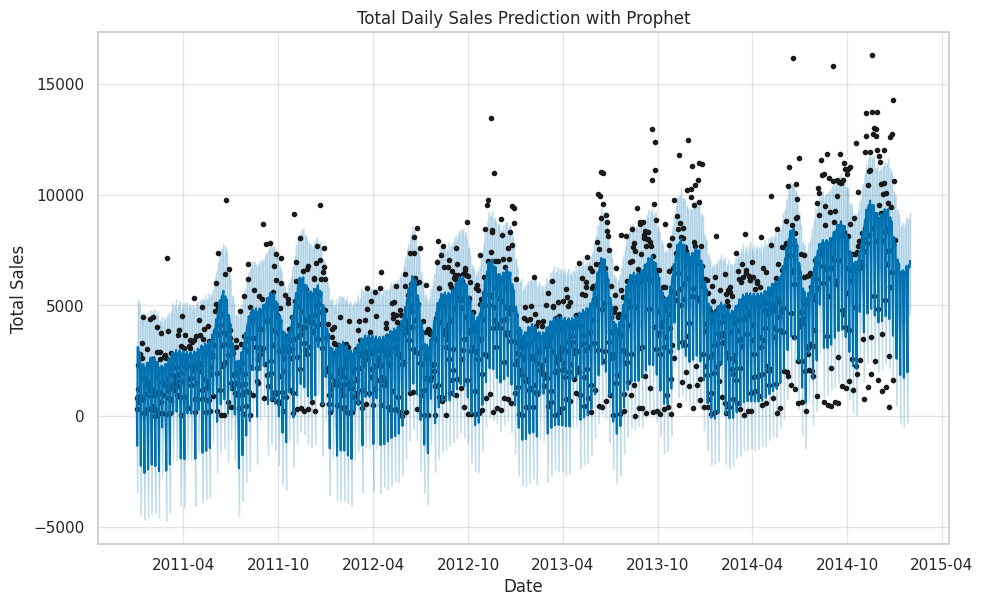

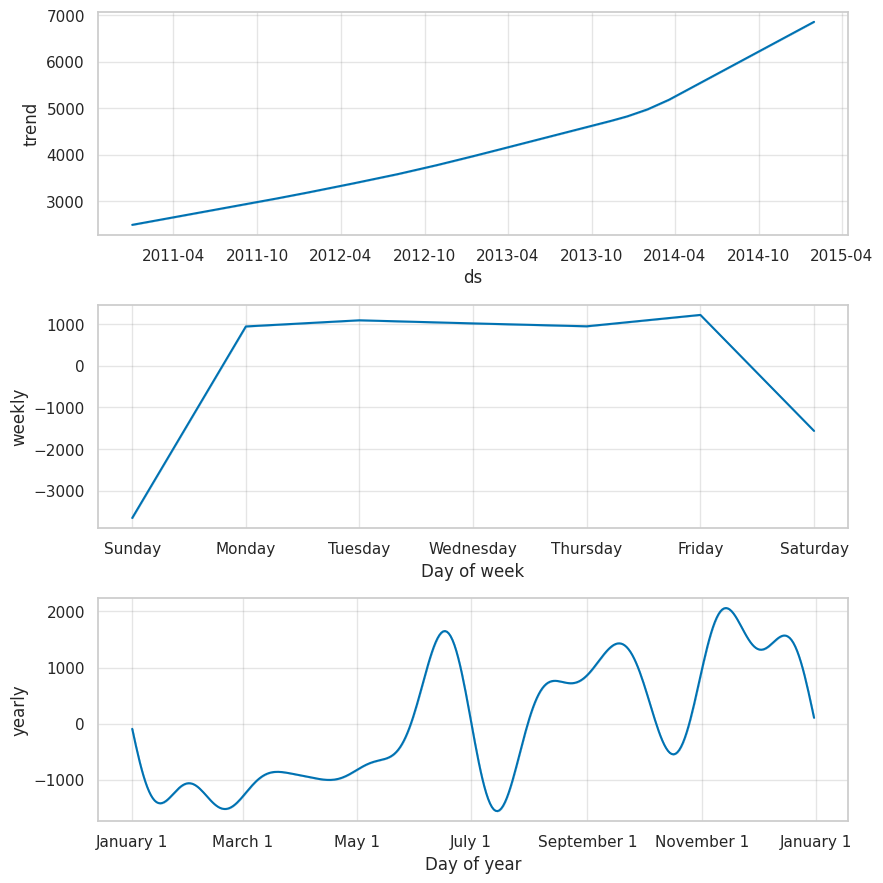


[INFO] Time Series modeling with Prophet is complete and visualization is displayed.

The first few lines of the prediction results:
          ds        trend   yhat_lower   yhat_upper  trend_lower  trend_upper  \
0 2011-01-01  2486.035139 -1212.434826  3208.819900  2486.035139  2486.035139   
1 2011-01-02  2487.826358 -3444.419543   926.296270  2487.826358  2487.826358   
2 2011-01-03  2489.617577   888.953065  5074.839527  2489.617577  2489.617577   
3 2011-01-04  2491.408795   942.378871  5246.183678  2491.408795  2491.408795   
4 2011-01-05  2493.200014   541.142639  5033.844992  2493.200014  2493.200014   

   additive_terms  additive_terms_lower  additive_terms_upper       weekly  \
0    -1581.348980          -1581.348980          -1581.348980 -1566.298101   
1    -3832.230251          -3832.230251          -3832.230251 -3660.399078   
2      619.415815            619.415815            619.415815   944.857205   
3      618.897310            618.897310            618.897310  1092

In [264]:
# Assumption: df_orders_ts already exists and is a copy of the clean data

# Make sure the 'Order Date' column is of type datetime
df_orders_ts['Order Date'] = pd.to_datetime(df_orders_ts['Order Date'])

# Aggregate total daily sales
daily_sales = df_orders_ts.groupby('Order Date')['Sales'].sum().reset_index()
daily_sales = daily_sales.rename(columns={'Order Date': 'ds', 'Sales': 'y'})

# Initialize and train the Prophet model
model = Prophet()
model.fit(daily_sales)

# Create a dataframe for future predictions (e.g., 30 days)
future = model.make_future_dataframe(periods=30)

# Make a prediction
forecast = model.predict(future)

# Visualize the prediction results
fig = model.plot(forecast)
plt.title('Total Daily Sales Prediction with Prophet')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.show()

# Visualize the prediction components (trend, seasonality)
fig2 = model.plot_components(forecast)
plt.show()

print("\n[INFO] Time Series modeling with Prophet is complete and visualization is displayed.")
print("\nThe first few lines of the prediction results:")
print(forecast.head())

22:08:37 - cmdstanpy - INFO - Chain [1] start processing
22:08:38 - cmdstanpy - INFO - Chain [1] done processing



[INFO] Prophet Model Evaluation:
Mean Squared Error (MSE): 5739904.97
Root Mean Squared Error (RMSE): 2395.81
Mean Absolute Error (MAE): 1826.88


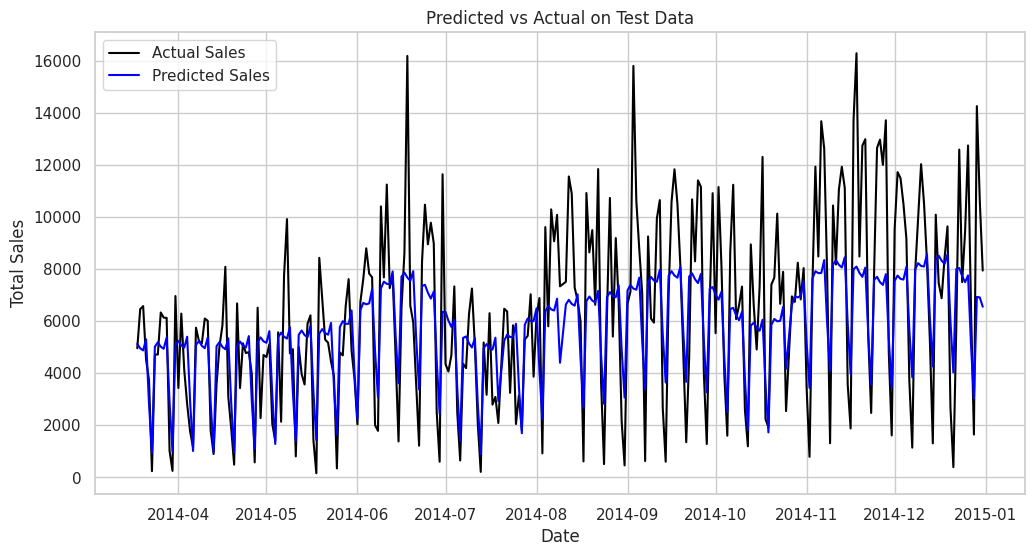

In [265]:
# Assumptions: daily_sales DataFrame already exists (previous aggregation result)

# Determine the split point for train and test (e.g., 80% of the original data for train)
train_size = int(len(daily_sales) * 0.8)
train_data = daily_sales[:train_size]
test_data = daily_sales[train_size:]

# Initialize and train the Prophet model on the train data
model_eval = Prophet()
model_eval.fit(train_data)

# Create a dataframe for predictions on the test period
future_test = pd.DataFrame(test_data['ds'])

# Make predictions on the test period
forecast_test = model_eval.predict(future_test)

# Combine the actual values ​​(y) from test_data with the predictions (yhat) from forecast_test
predictions = forecast_test[['ds', 'yhat']].set_index('ds')
actuals = test_data[['ds', 'y']].set_index('ds')
comparison = predictions.join(actuals)

# Calculate evaluation metrics
mse = mean_squared_error(comparison['y'], comparison['yhat'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(comparison['y'], comparison['yhat'])

print("\n[INFO] Prophet Model Evaluation:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

# Visualize predicted vs actual results on data test
plt.figure(figsize=(12, 6))
plt.plot(actuals['y'], label='Actual Sales', color='black')
plt.plot(predictions['yhat'], label='Predicted Sales', color='blue')
plt.title('Predicted vs Actual on Test Data')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.show()

22:08:38 - cmdstanpy - INFO - Chain [1] start processing
22:08:38 - cmdstanpy - INFO - Chain [1] done processing
22:08:38 - cmdstanpy - INFO - Chain [1] start processing
22:08:38 - cmdstanpy - INFO - Chain [1] done processing
22:08:39 - cmdstanpy - INFO - Chain [1] start processing
22:08:39 - cmdstanpy - INFO - Chain [1] done processing
22:08:39 - cmdstanpy - INFO - Chain [1] start processing
22:08:39 - cmdstanpy - INFO - Chain [1] done processing
22:08:39 - cmdstanpy - INFO - Chain [1] start processing



[INFO] Result of Basic Tuning for changepoint_prior_scale:
changepoint_prior_scale = 0.001: RMSE = 2420.18
changepoint_prior_scale = 0.01: RMSE = 2410.46
changepoint_prior_scale = 0.1: RMSE = 2380.55
changepoint_prior_scale = 0.5: RMSE = 2431.83

Best changepoint_prior_scale value (based on lowest RMSE): 0.1


22:08:39 - cmdstanpy - INFO - Chain [1] done processing


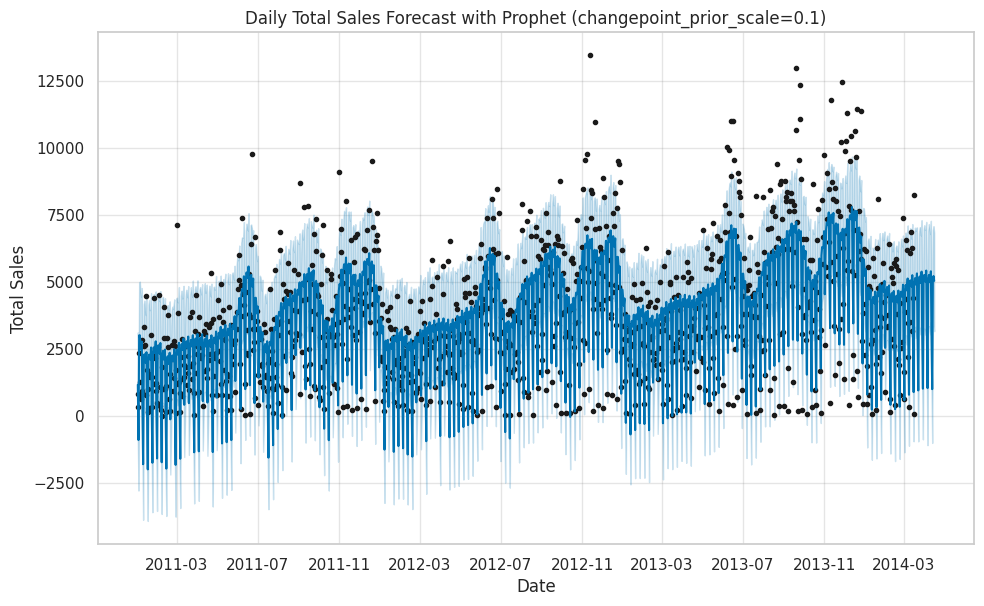

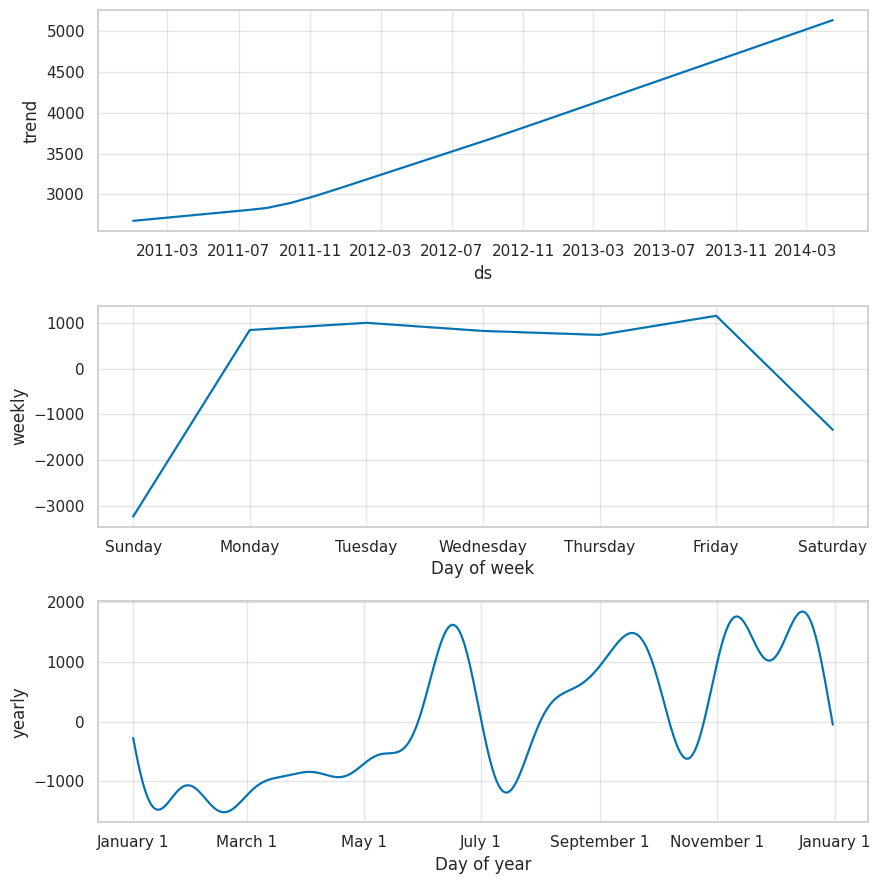

In [266]:
# Assumption: train_data and test_data already exist

param_values = [0.001, 0.01, 0.1, 0.5]
results = {}

for p in param_values:
    model_tuned = Prophet(changepoint_prior_scale=p)
    model_tuned.fit(train_data)
    future_test = pd.DataFrame(test_data['ds'])
    forecast_test = model_tuned.predict(future_test)
    predictions = forecast_test[['ds', 'yhat']].set_index('ds')
    actuals = test_data[['ds', 'y']].set_index('ds')
    mse = mean_squared_error(actuals['y'], predictions['yhat'])
    rmse = np.sqrt(mse)
    results[p] = rmse

# Print the result of basic parameter tuning
best_param = min(results, key=results.get)
print("\n[INFO] Result of Basic Tuning for changepoint_prior_scale:")
for param, rmse in results.items():
    print(f"changepoint_prior_scale = {param}: RMSE = {rmse:.2f}")
print(f"\nBest changepoint_prior_scale value (based on lowest RMSE): {best_param}")

# Train the final model using the best parameter on the full training data
best_model = Prophet(changepoint_prior_scale=best_param)
best_model.fit(train_data)
future_forecast = best_model.make_future_dataframe(periods=30)
forecast = best_model.predict(future_forecast)

# Visualize the forecast results using the tuned model
fig = best_model.plot(forecast)
plt.title(f'Daily Total Sales Forecast with Prophet (changepoint_prior_scale={best_param})')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.show()

fig2 = best_model.plot_components(forecast)
plt.show()

In [267]:
# Assumption: df_orders_ts already exists and contains columns 'Order Date' and 'Discount'

# Daily Discount Average Aggregation
daily_discount = df_orders_ts.groupby('Order Date')['Discount'].mean().reset_index()
daily_discount = daily_discount.rename(columns={'Order Date': 'ds', 'Discount': 'Discount_avg'})

print("[INFO] DataFrame daily_discount has been created:")
print(daily_discount.head())

[INFO] DataFrame daily_discount has been created:
          ds  Discount_avg
0 2011-01-01      0.133333
1 2011-01-02      0.000000
2 2011-01-03      0.186000
3 2011-01-04      0.112625
4 2011-01-05      0.171429


In [268]:
# Assumptions: df_orders_ts already exists, and train_data and test_data are already defined

# 1. Daily Discount Average Aggregation
daily_discount = df_orders_ts.groupby('Order Date')['Discount'].mean().reset_index()
daily_discount = daily_discount.rename(columns={'Order Date': 'ds', 'Discount': 'Discount_avg'})

# 2. Merge with Daily Sales Data (on train and test data)
train_data_merged = pd.merge(train_data, daily_discount, on='ds', how='left')
test_data_merged = pd.merge(test_data, daily_discount, on='ds', how='left')

# Make sure there are no NaNs after the merge (if there are, you need to handled)
train_data_merged['Discount_avg'] = train_data_merged['Discount_avg'].fillna(train_data_merged['Discount_avg'].mean())
test_data_merged['Discount_avg'] = test_data_merged['Discount_avg'].fillna(test_data_merged['Discount_avg'].mean())

# 3. Train the Prophet Model with Regressors on the train data
model_with_regressor = Prophet()
model_with_regressor.add_regressor('Discount_avg')
model_with_regressor.fit(train_data_merged)

# 4. Make Predictions on Test Data with Regressors
future_test_with_regressor = pd.DataFrame(test_data_merged[['ds', 'Discount_avg']])
forecast_test_with_regressor = model_with_regressor.predict(future_test_with_regressor)

# Model Evaluation with Regressors
predictions_with_regressor = forecast_test_with_regressor[['ds', 'yhat']].set_index('ds')
actuals_test = test_data_merged[['ds', 'y']].set_index('ds')
comparison_with_regressor = predictions_with_regressor.join(actuals_test)

mse_with_regressor = mean_squared_error(comparison_with_regressor['y'], comparison_with_regressor['yhat'])
rmse_with_regressor = np.sqrt(mse_with_regressor)
mae_with_regressor = mean_absolute_error(comparison_with_regressor['y'], comparison_with_regressor['yhat'])

print("\n[INFO] Evaluate Prophet Model with Regressor (Average Daily Discount):")
print(f"Mean Squared Error (MSE): {mse_with_regressor:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_with_regressor:.2f}")
print(f"Mean Absolute Error (MAE): {mae_with_regressor:.2f}")

22:08:41 - cmdstanpy - INFO - Chain [1] start processing
22:08:41 - cmdstanpy - INFO - Chain [1] done processing



[INFO] Evaluate Prophet Model with Regressor (Average Daily Discount):
Mean Squared Error (MSE): 5717361.22
Root Mean Squared Error (RMSE): 2391.10
Mean Absolute Error (MAE): 1823.12


In [269]:
output_dir = "../data/processed/"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save the forecast DataFrame to a CSV file
# We only need the 'ds', 'yhat', 'yhat_lower', and 'yhat_upper' columns
# Customize the filenames if you want to differentiate between the original model forecast and the tuned model.
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv(
    os.path.join(output_dir, "prophet_daily_sales_forecast.csv"),
    index=False
)

print(f"[INFO] Prophet forecast data successfully saved to: {os.path.join(output_dir, 'prophet_daily_sales_forecast.csv')}")

[INFO] Prophet forecast data successfully saved to: ../data/processed/prophet_daily_sales_forecast.csv


---

## RFM

In [270]:
# --- Bagian 1: Perhitungan RFM Metrics (Recency, Frequency, Monetary) ---
# Assumption: df_orders_ca already exists and contains transaction data with 'Customer ID', 'Order Date', and 'Sales' columns

# Convert 'Order Date' to datetime if not already
df_orders_ca['Order Date'] = pd.to_datetime(df_orders_ca['Order Date'])

# Define the analysis date
analysis_date = df_orders_ca['Order Date'].max() + pd.Timedelta(days=1)

# Calculate Recency
recency_df = df_orders_ca.groupby('Customer ID')['Order Date'].max().reset_index()
recency_df['Recency'] = (analysis_date - recency_df['Order Date']).dt.days
recency_df = recency_df[['Customer ID', 'Recency']]

# Calculate Frequency
frequency_df = df_orders_ca.groupby('Customer ID')['Order ID'].nunique().reset_index()
frequency_df.columns = ['Customer ID', 'Frequency']

# Calculate Monetary Value
monetary_df = df_orders_ca.groupby('Customer ID')['Sales'].sum().reset_index()
monetary_df.columns = ['Customer ID', 'Monetary']

# Merge all RFM metrics into a single DataFrame
rfm_df = recency_df.merge(frequency_df, on='Customer ID')
rfm_df = rfm_df.merge(monetary_df, on='Customer ID')

print("[INFO] RFM DataFrame (Initial):")
print(rfm_df.head())

[INFO] RFM DataFrame (Initial):
  Customer ID  Recency  Frequency     Monetary
0    AA-10315        9         19  13747.41300
1    AA-10375        7         23   5884.19500
2    AA-10480      126         20  17695.58978
3    AA-10645       29         36  15343.89070
4      AA-315        3          7   2243.25600


In [271]:
# --- DEBUGGING STEP 1: Check the RFM DataFrame content ---
print("\n--- DEBUGGING: RFM DataFrame Content Check ---")
print("Is rfm_df empty?", rfm_df.empty)
print("Number of rows in rfm_df:", len(rfm_df))
print("\nMissing values in RFM columns:")
print(rfm_df[['Recency', 'Frequency', 'Monetary']].isnull().sum())
print("\nDescriptive statistics for RFM columns:")
print(rfm_df[['Recency', 'Frequency', 'Monetary']].describe())
print("---------------------------------------------")


--- DEBUGGING: RFM DataFrame Content Check ---
Is rfm_df empty? False
Number of rows in rfm_df: 1590

Missing values in RFM columns:
Recency      0
Frequency    0
Monetary     0
dtype: int64

Descriptive statistics for RFM columns:
           Recency    Frequency      Monetary
count  1590.000000  1590.000000   1590.000000
mean     85.432704    16.196855   7951.729503
std     127.746455    10.619199   6937.118160
min       1.000000     1.000000      7.173000
25%      15.000000     6.000000   1674.812250
50%      36.000000    14.000000   6248.135590
75%     100.000000    26.000000  13133.098420
max    1207.000000    41.000000  35668.120800
---------------------------------------------


In [272]:
# --- Bagian 2: RFM Scoring (menggunakan pd.qcut untuk robustness) ---
# Tentukan jumlah segmen (misalnya, 5 untuk skor 1 hingga 5)
segment_count = 5

# Gunakan pd.qcut untuk membagi data ke dalam kuantil dan memberikan label skor
# Untuk Recency: Skor 5 adalah yang paling baru (nilai kecil), jadi labelnya dibalik
rfm_df['R_Score'] = pd.qcut(
    rfm_df['Recency'],
    q=segment_count,
    labels=range(segment_count, 0, -1), # labels=[5, 4, 3, 2, 1]
    duplicates='drop' # Tangani jika ada nilai duplikat di kuantil batas
).astype(int)

# Untuk Frequency dan Monetary: Skor 5 adalah yang paling tinggi (nilai besar), jadi labelnya normal
rfm_df['F_Score'] = pd.qcut(
    rfm_df['Frequency'],
    q=segment_count,
    labels=range(1, segment_count + 1), # labels=[1, 2, 3, 4, 5]
    duplicates='drop'
).astype(int)

rfm_df['M_Score'] = pd.qcut(
    rfm_df['Monetary'],
    q=segment_count,
    labels=range(1, segment_count + 1), # labels=[1, 2, 3, 4, 5]
    duplicates='drop'
).astype(int)

# Gabungkan skor RFM menjadi satu segmen string
rfm_df['RFM_Segment'] = rfm_df['R_Score'].astype(str) + \
                        rfm_df['F_Score'].astype(str) + \
                        rfm_df['M_Score'].astype(str)

# Hitung skor RFM gabungan (jumlah skor)
rfm_df['RFM_Score'] = rfm_df[['R_Score', 'F_Score', 'M_Score']].sum(axis=1)

print("\n[INFO] RFM DataFrame after Scoring (menggunakan pd.qcut):")
print(rfm_df.head())


[INFO] RFM DataFrame after Scoring (menggunakan pd.qcut):
  Customer ID  Recency  Frequency     Monetary  R_Score  F_Score  M_Score  \
0    AA-10315        9         19  13747.41300        5        3        4   
1    AA-10375        7         23   5884.19500        5        4        3   
2    AA-10480      126         20  17695.58978        1        3        5   
3    AA-10645       29         36  15343.89070        3        5        5   
4      AA-315        3          7   2243.25600        5        2        2   

  RFM_Segment  RFM_Score  
0         534         12  
1         543         12  
2         135          9  
3         355         13  
4         522          9  



[INFO] Determining Optimal K for K-Means using Elbow Method...


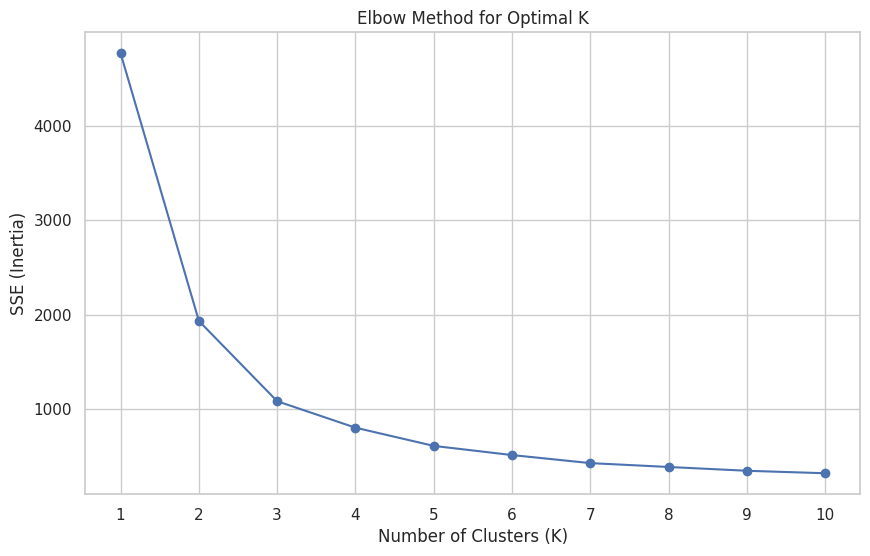


[INFO] Review the Elbow plot above to select the optimal 'n_clusters'.

[INFO] Optimal number of clusters selected: 3

[INFO] RFM DataFrame with K-Means Clusters:
  Customer ID  Recency  Frequency     Monetary  R_Score  F_Score  M_Score  \
0    AA-10315        9         19  13747.41300        5        3        4   
1    AA-10375        7         23   5884.19500        5        4        3   
2    AA-10480      126         20  17695.58978        1        3        5   
3    AA-10645       29         36  15343.89070        3        5        5   
4      AA-315        3          7   2243.25600        5        2        2   

  RFM_Segment  RFM_Score  Cluster  
0         534         12        1  
1         543         12        1  
2         135          9        1  
3         355         13        1  
4         522          9        2  


In [273]:
# --- Bagian 3: K-Means Clustering for Customer Segmentation ---
# Pilih fitur RFM untuk clustering
rfm_features = ['Recency', 'Frequency', 'Monetary']
X = rfm_df[rfm_features]

# Standardisasi fitur agar memiliki mean 0 dan varians 1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Menentukan Optimal K untuk K-Means menggunakan Elbow Method ---
print("\n[INFO] Determining Optimal K for K-Means using Elbow Method...")
sse = {} # Sum of Squared Errors
for k in range(1, 11): # Coba k dari 1 hingga 10
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    sse[k] = kmeans.inertia_ # Inertia adalah SSE

# Plot the Elbow Method results
plt.figure(figsize=(10, 6))
plt.plot(list(sse.keys()), list(sse.values()), marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('SSE (Inertia)')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

print("\n[INFO] Review the Elbow plot above to select the optimal 'n_clusters'.")

# --- LANGKAH PENTING: Pilih K yang Optimal di SINI ---
# Contoh: Jika Anda melihat Elbow ada di k=3, maka:
n_clusters_optimal = 3 # <--- GANTI ANGKA INI DENGAN K YANG ANDA PILIH DARI PLOT ELBOW ANDA

print(f"\n[INFO] Optimal number of clusters selected: {n_clusters_optimal}")

# Latih model K-Means dengan K yang optimal
kmeans = KMeans(n_clusters=n_clusters_optimal, random_state=42, n_init=10)
rfm_df['Cluster'] = kmeans.fit_predict(X_scaled)

print("\n[INFO] RFM DataFrame with K-Means Clusters:")
print(rfm_df.head())

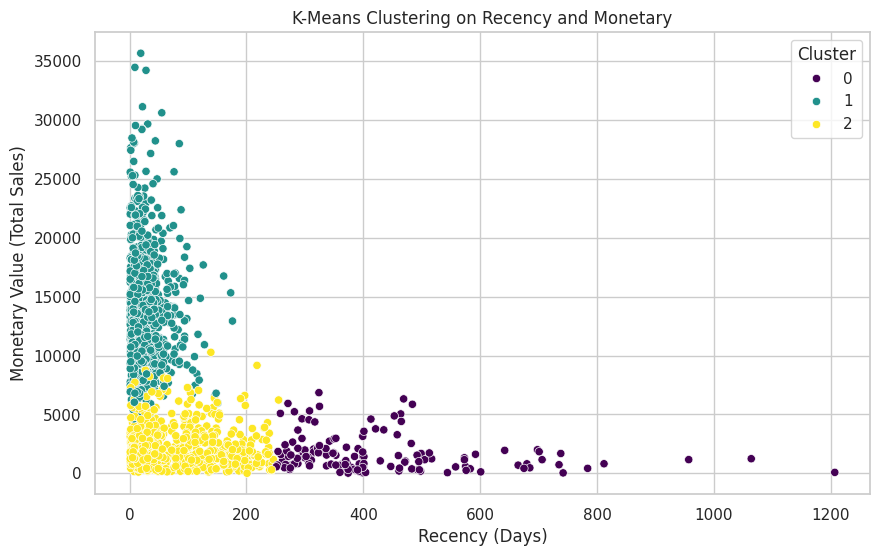

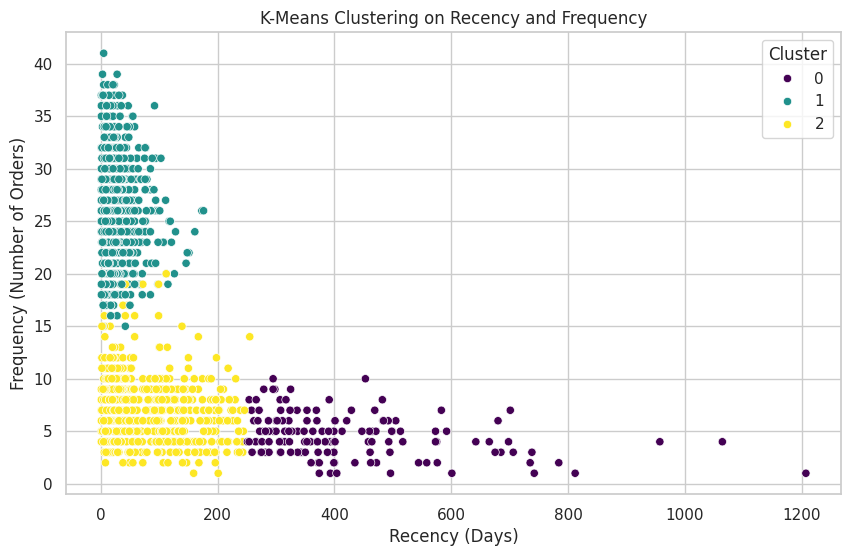

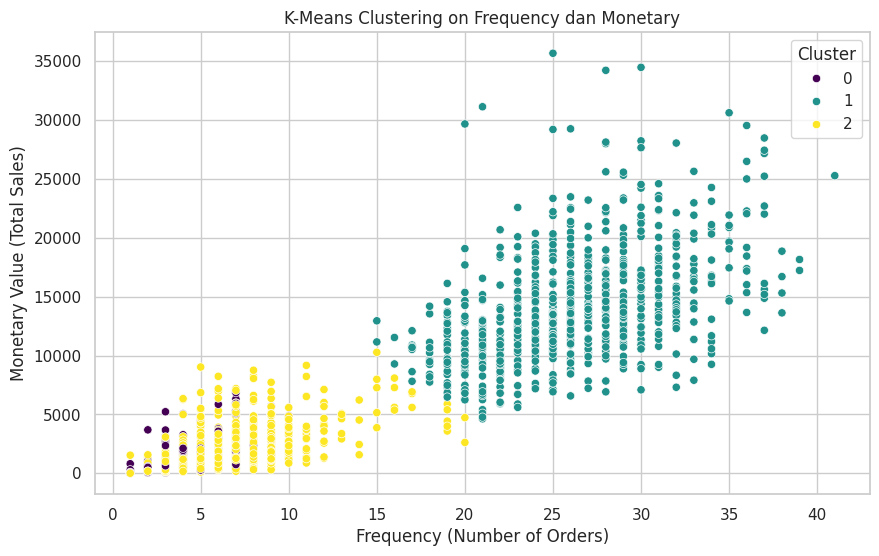


[INFO] Cluster Sizes:
Cluster
0    143
1    773
2    674
Name: count, dtype: int64

[INFO] Mean RFM values per Cluster (for interpretation):
            Recency  Frequency      Monetary
Cluster                                     
0        421.349650   4.538462   1663.781926
1         28.345408  26.331177  14047.178125
2         79.635015   7.047478   2295.045110


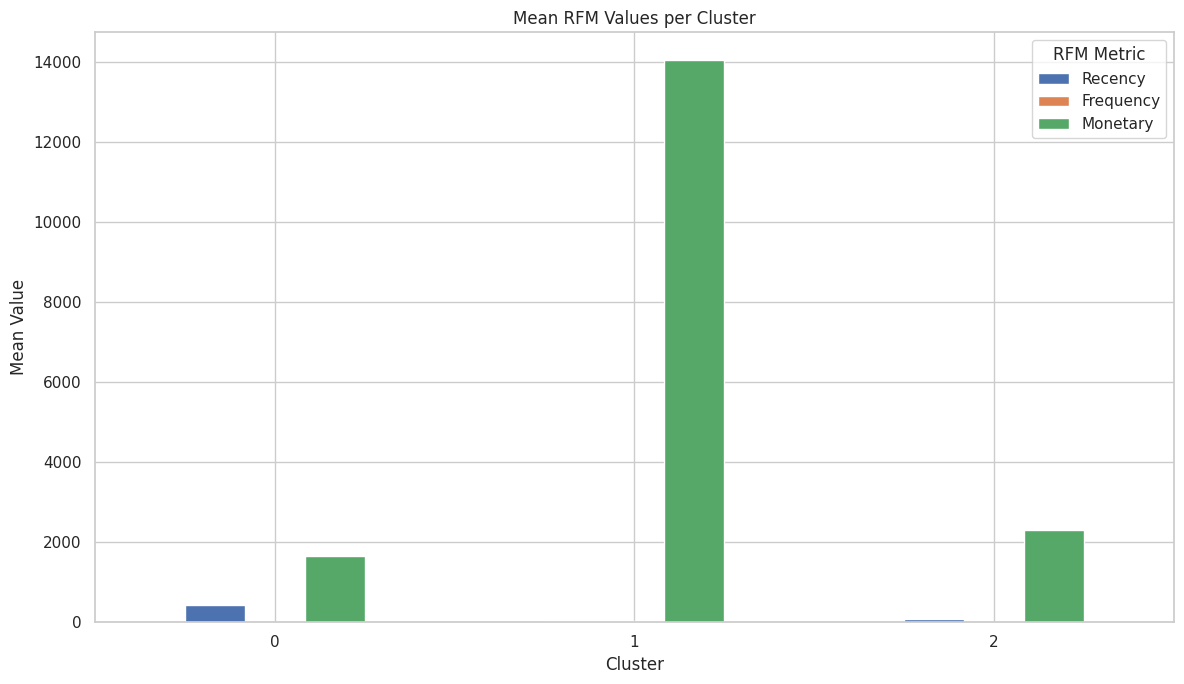


[INFO] Mean RFM Scores per Cluster:
          R_Score   F_Score   M_Score  RFM_Score
Cluster                                         
0        1.000000  1.202797  1.608392   3.811189
1        3.737387  4.160414  4.232859  12.130660
2        2.609792  1.787834  1.881306   6.278932


In [274]:
# --- Bagian 4: Visualisasi dan Analisis Cluster ---
# Visualisasi cluster (hanya untuk 2 fitur pada satu waktu)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm_df, x='Recency', y='Monetary', hue='Cluster', palette='viridis')
plt.title('K-Means Clustering on Recency and Monetary')
plt.xlabel('Recency (Days)')
plt.ylabel('Monetary Value (Total Sales)')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm_df, x='Recency', y='Frequency', hue='Cluster', palette='viridis')
plt.title('K-Means Clustering on Recency and Frequency')
plt.xlabel('Recency (Days)')
plt.ylabel('Frequency (Number of Orders)')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm_df, x='Frequency', y='Monetary', hue='Cluster', palette='viridis')
plt.title('K-Means Clustering on Frequency dan Monetary')
plt.xlabel('Frequency (Number of Orders)')
plt.ylabel('Monetary Value (Total Sales)')
plt.show()

# Analisis ukuran cluster
print("\n[INFO] Cluster Sizes:")
print(rfm_df['Cluster'].value_counts().sort_index())

# Analisis mean RFM values per cluster
print("\n[INFO] Mean RFM values per Cluster (for interpretation):")
cluster_profiles = rfm_df.groupby('Cluster')[rfm_features].mean()
print(cluster_profiles)

# Visualisasi Bar Plot untuk Profil Cluster (lebih mudah diinterpretasi)
cluster_profiles.plot(kind='bar', figsize=(12, 7))
plt.title('Mean RFM Values per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Mean Value')
plt.xticks(rotation=0)
plt.legend(title='RFM Metric')
plt.tight_layout()
plt.show()

# Jika Anda juga ingin melihat distribusi skor (bukan hanya nilai mentah)
print("\n[INFO] Mean RFM Scores per Cluster:")
cluster_score_profiles = rfm_df.groupby('Cluster')[['R_Score', 'F_Score', 'M_Score', 'RFM_Score']].mean()
print(cluster_score_profiles)


In [275]:
# Pastikan folder target ada, jika belum, akan dibuat
output_dir = "../data/processed/"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save DataFrame to CSV
rfm_df.to_csv(os.path.join(output_dir, "processed_rfm_segments.csv"), index=False)

print(f"[INFO] RFM segments DataFrame saved successfully to: {os.path.join(output_dir, 'processed_rfm_segments.csv')}")

[INFO] RFM segments DataFrame saved successfully to: ../data/processed/processed_rfm_segments.csv


---

## Autoencoder

In [276]:
# --- Autoencoder for RFM Analysis ---

# --- 1. Data Preparation ---
# Assumption: rfm_df already exists from previous steps, containing 'Recency', 'Frequency', 'Monetary'
rfm_features = ['Recency', 'Frequency', 'Monetary']
X = rfm_df[rfm_features]

# Standardize features (crucial for neural networks)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("[INFO] RFM features scaled successfully.")
print(f"Shape of scaled data: {X_scaled.shape}")

[INFO] RFM features scaled successfully.
Shape of scaled data: (1590, 3)



[INFO] Starting Autoencoder training...
[INFO] Autoencoder training complete.


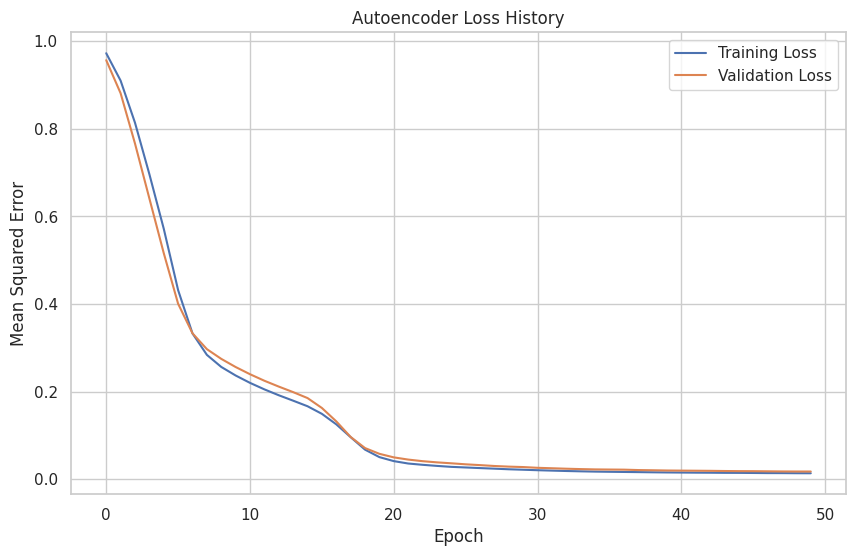

In [277]:
# --- 2. Building and Training the Autoencoder Model ---
# Define the Autoencoder architecture
input_dim = X_scaled.shape[1] # Number of input features (3: Recency, Frequency, Monetary)
latent_dim = 2 # Dimensionality of the latent space (e.g., 2 for easy visualization)

# Encoder part
input_layer = Input(shape=(input_dim,))
encoder_layer = Dense(8, activation='relu')(input_layer) # Example hidden layer
encoder_layer = Dense(4, activation='relu')(encoder_layer)
latent_space = Dense(latent_dim, activation='relu', name='latent_space')(encoder_layer)

# Decoder part
decoder_layer = Dense(4, activation='relu')(latent_space)
decoder_layer = Dense(8, activation='relu')(decoder_layer)
output_layer = Dense(input_dim, activation='linear')(decoder_layer) # Output layer should be linear for scaled data

# Combine to form the Autoencoder model
autoencoder = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mse') # Adam optimizer, Mean Squared Error loss

# Train the model
print("\n[INFO] Starting Autoencoder training...")
history = autoencoder.fit(X_scaled, X_scaled, # Input and target are the same for autoencoders
                          epochs=50, # Number of training iterations
                          batch_size=32, # Number of samples per gradient update
                          shuffle=True, # Shuffle data before each epoch
                          validation_split=0.2, # Use 20% of data for validation
                          verbose=0) # Set verbose=1 to see training progress

print("[INFO] Autoencoder training complete.")

# Plot loss history to check for convergence and overfitting
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Loss History')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

In [278]:
# --- 3. Extracting Features from the Latent Space ---
# Create an encoder-only model to get the latent space representation
encoder = Model(inputs=input_layer, outputs=latent_space)

# Get the RFM representation in the latent space
X_latent = encoder.predict(X_scaled)

print("\n[INFO] Shape of latent space features:", X_latent.shape)
print("First 5 latent features:\n", X_latent[:5])

50/50 [==============================] - 0s 4ms/step

[INFO] Shape of latent space features: (1590, 2)
First 5 latent features:
 [[0.59046984 0.4804749 ]
 [0.7994015  0.14338648]
 [0.62157154 1.0271788 ]
 [0.32271624 0.10982949]
 [1.7839535  0.84305406]]


In [279]:
# --- 4. Clustering on the Latent Space ---
# Determine the number of clusters (e.g., 3, or based on Elbow Method applied to X_latent)
# You might want to re-run the Elbow method here on X_latent if you want to find the optimal clusters for these new features.
n_clusters_autoencoder = 3 # Adjust this if you perform Elbow Method again on X_latent

# Train K-Means on the learned latent space features
kmeans_latent = KMeans(n_clusters=n_clusters_autoencoder, random_state=42, n_init=10)
rfm_df['Cluster_AE'] = kmeans_latent.fit_predict(X_latent)

print("\n[INFO] RFM DataFrame with Autoencoder K-Means Clusters:")
print(rfm_df.head())


[INFO] RFM DataFrame with Autoencoder K-Means Clusters:
  Customer ID  Recency  Frequency     Monetary  R_Score  F_Score  M_Score  \
0    AA-10315        9         19  13747.41300        5        3        4   
1    AA-10375        7         23   5884.19500        5        4        3   
2    AA-10480      126         20  17695.58978        1        3        5   
3    AA-10645       29         36  15343.89070        3        5        5   
4      AA-315        3          7   2243.25600        5        2        2   

  RFM_Segment  RFM_Score  Cluster  Cluster_AE  
0         534         12        1           1  
1         543         12        1           1  
2         135          9        1           1  
3         355         13        1           1  
4         522          9        2           2  


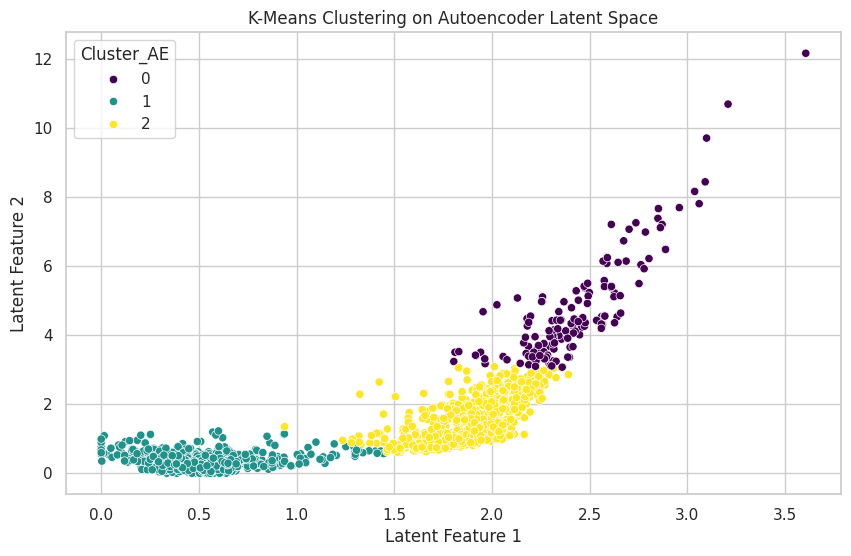


[INFO] Mean RFM values per Autoencoder Cluster:
               Recency  Frequency      Monetary
Cluster_AE                                     
0           424.621429   4.442857   1600.870939
1            28.501244  25.895522  13717.063895
2            82.780186   6.673375   2152.644903


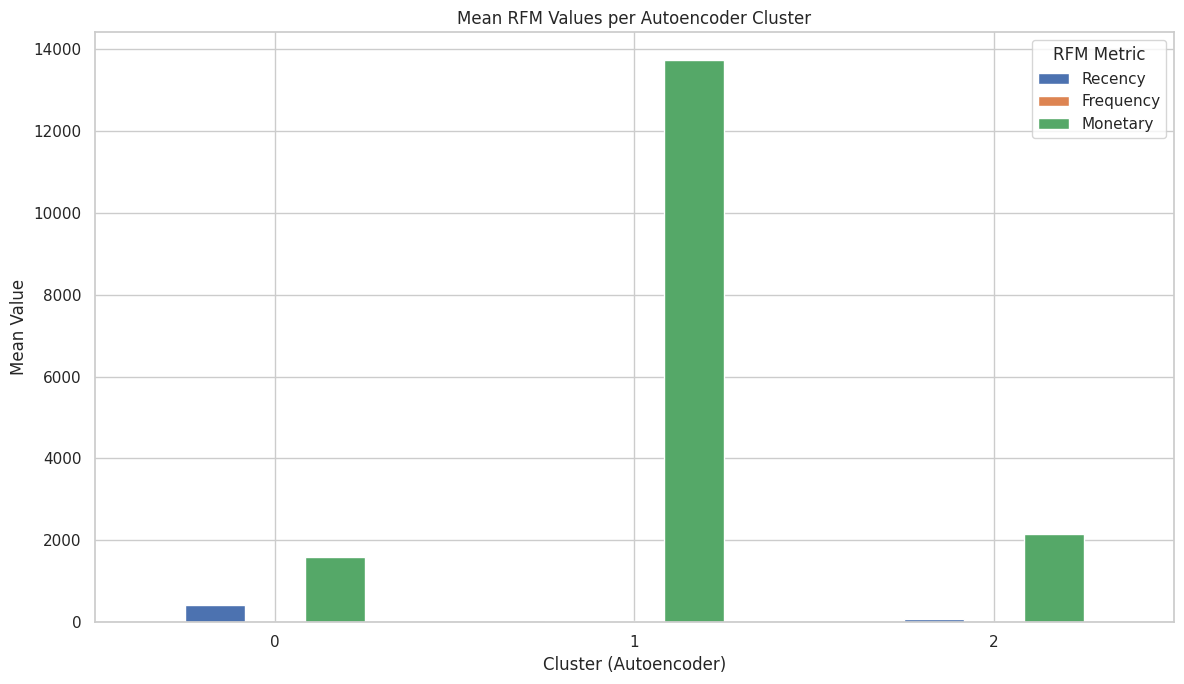

In [280]:
# --- 5. Cluster Visualization and Analysis for Autoencoder Clusters ---
# If latent_dim = 2, it can be visualized directly
if latent_dim == 2:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=X_latent[:, 0], y=X_latent[:, 1], hue=rfm_df['Cluster_AE'], palette='viridis')
    plt.title('K-Means Clustering on Autoencoder Latent Space')
    plt.xlabel('Latent Feature 1')
    plt.ylabel('Latent Feature 2')
    plt.show()

# Analyze mean RFM values per cluster (crucial for interpretation)
print("\n[INFO] Mean RFM values per Autoencoder Cluster:")
# Use the original RFM features to profile the clusters in interpretable metrics
cluster_profiles_ae = rfm_df.groupby('Cluster_AE')[rfm_features].mean()
print(cluster_profiles_ae)

# Visualize Bar Plot for Autoencoder Cluster Profiles
cluster_profiles_ae.plot(kind='bar', figsize=(12, 7))
plt.title('Mean RFM Values per Autoencoder Cluster')
plt.xlabel('Cluster (Autoencoder)')
plt.ylabel('Mean Value')
plt.xticks(rotation=0)
plt.legend(title='RFM Metric')
plt.tight_layout()
plt.show()

In [281]:
# --- Saving the results (Optional) ---
# Ensure the target folder exists; create it if it doesn't
output_dir = "../data/processed/"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save the DataFrame with Autoencoder clusters to a CSV file
rfm_df.to_csv(os.path.join(output_dir, "processed_rfm_autoencoder_segments.csv"), index=False)

print(f"[INFO] RFM segments DataFrame with Autoencoder clusters successfully saved to: {os.path.join(output_dir, 'processed_rfm_autoencoder_segments.csv')}")

[INFO] RFM segments DataFrame with Autoencoder clusters successfully saved to: ../data/processed/processed_rfm_autoencoder_segments.csv


---

## Recommendation System Based on Autoencoder Clusters

In [282]:
# Assume df_orders_ca and rfm_df exist from previous sessions.
# Make sure rfm_df has 'Customer ID' and 'Cluster_AE' columns.

# Merge cluster information from rfm_df into df_orders_ca
# We only need 'Customer ID' and 'Cluster_AE' from rfm_df for merging.
df_orders_ca_with_clusters = pd.merge(
    df_orders_ca,
    rfm_df[['Customer ID', 'Cluster_AE']],
    on='Customer ID',
    how='left' # Use a left merge to keep all original transactions
)

print("[INFO] df_orders_ca_with_clusters (first 5 rows):")
print(df_orders_ca_with_clusters.head())
print(f"Missing Cluster_AE values: {df_orders_ca_with_clusters['Cluster_AE'].isnull().sum()}")

# Drop rows where Cluster_AE might be NaN (if some customer IDs in df_orders_ca were not in rfm_df)
df_orders_ca_with_clusters.dropna(subset=['Cluster_AE'], inplace=True)
df_orders_ca_with_clusters['Cluster_AE'] = df_orders_ca_with_clusters['Cluster_AE'].astype(int)

print(f"Shape after dropping NaNs: {df_orders_ca_with_clusters.shape}")

# Re-initialize scaler here if you've restarted your kernel, as it's needed for the recommendation function.
# This assumes rfm_features is ['Recency', 'Frequency', 'Monetary'] and X_scaled was created from X.
scaler = StandardScaler()
# It's important to fit the scaler on the original data used for training the autoencoder
# For this example, we'll assume X (rfm_df[rfm_features]) was used to fit the scaler.
# In a full pipeline, you'd save and load this scaler.
scaler.fit(rfm_df[rfm_features])

[INFO] df_orders_ca_with_clusters (first 5 rows):
   Row ID         Order ID Order Date  Ship Date     Ship Mode Customer ID  \
0   32298   CA-2012-124891 2012-07-31 2012-07-31      Same Day    RH-19495   
1   26341    IN-2013-77878 2013-02-05 2013-02-07  Second Class    JR-16210   
2   25330    IN-2013-71249 2013-10-17 2013-10-18   First Class    CR-12730   
3   13524  ES-2013-1579342 2013-01-28 2013-01-30   First Class    KM-16375   
4   47221     SG-2013-4320 2013-11-05 2013-11-06      Same Day     RH-9495   

      Customer Name      Segment           City            State  \
0       Rick Hansen     Consumer  New York City         New York   
1     Justin Ritter    Corporate     Wollongong  New South Wales   
2      Craig Reiter     Consumer       Brisbane       Queensland   
3  Katherine Murray  Home Office         Berlin           Berlin   
4       Rick Hansen     Consumer          Dakar            Dakar   

         Country  Market   Region        Product ID    Category Sub-Cate

StandardScaler()

In [283]:
# Analyze top products/categories per cluster
print("\n[INFO] Top 5 Categories per Autoencoder Cluster:")
cluster_top_categories = {}
for cluster_id in sorted(df_orders_ca_with_clusters['Cluster_AE'].unique()):
    # Filter data for the current cluster
    cluster_data = df_orders_ca_with_clusters[df_orders_ca_with_clusters['Cluster_AE'] == cluster_id]

    # Count frequency of categories
    top_categories = cluster_data['Category'].value_counts().head(5) # Adjust 'head(5)' for desired Top N recommendations

    cluster_top_categories[cluster_id] = top_categories
    print(f"\n--- Cluster {cluster_id} ---")
    print(top_categories)

# You can also do this for Product Name if you want more specific recommendations
print("\n[INFO] Top 5 Product Names per Autoencoder Cluster (Example for Cluster 1):")
# Example for a specific cluster; iterate through all clusters if needed
if 1 in df_orders_ca_with_clusters['Cluster_AE'].unique():
    cluster_1_products = df_orders_ca_with_clusters[df_orders_ca_with_clusters['Cluster_AE'] == 1]['Product Name'].value_counts().head(5)
    print(cluster_1_products)


[INFO] Top 5 Categories per Autoencoder Cluster:

--- Cluster 0 ---
Category
Office Supplies    812
Technology         268
Furniture          196
Name: count, dtype: int64

--- Cluster 1 ---
Category
Office Supplies    24823
Furniture           8458
Technology          8261
Name: count, dtype: int64

--- Cluster 2 ---
Category
Office Supplies    5640
Technology         1614
Furniture          1223
Name: count, dtype: int64

[INFO] Top 5 Product Names per Autoencoder Cluster (Example for Cluster 1):
Product Name
Staples                                  225
Eldon File Cart, Single Width             63
Cardinal Index Tab, Clear                 63
Rogers File Cart, Single Width            58
Stockwell Paper Clips, Assorted Sizes     55
Name: count, dtype: int64


In [284]:
# Assume the 'encoder' model (from the Autoencoder code)
# and 'kmeans_latent' model (from the clustering on latent space) are already trained and available.
# Also, 'rfm_features' (['Recency', 'Frequency', 'Monetary']) and 'scaler' should be available.

def recommend_items_for_customer(customer_id, rfm_df_original, df_orders_ca_clustered, encoder_model, kmeans_model, top_n=5):
    """
    Recommends items for a specific customer based on their Autoencoder cluster.

    Args:
        customer_id (str): The ID of the customer to get recommendations for.
        rfm_df_original (pd.DataFrame): The rfm_df DataFrame containing original RFM data.
        df_orders_ca_clustered (pd.DataFrame): The original transaction DataFrame merged with cluster info.
        encoder_model (tf.keras.Model): The trained Autoencoder encoder model.
        kmeans_model (sklearn.cluster.KMeans): The K-Means model trained on the latent space.
        top_n (int): The number of top items to recommend.

    Returns:
        pd.Series: The most popular items in that customer's cluster.
    """
    customer_rfm = rfm_df_original[rfm_df_original['Customer ID'] == customer_id]

    if customer_rfm.empty:
        print(f"Customer ID {customer_id} not found in RFM data.")
        return None

    # Get the scaled RFM features for this customer
    # Ensure rfm_features and scaler are correctly defined and fitted from previous steps.
    customer_rfm_scaled = scaler.transform(customer_rfm[rfm_features])

    # Predict the customer's position in the latent space
    customer_latent_feature = encoder_model.predict(customer_rfm_scaled, verbose=0)

    # Predict the customer's cluster
    customer_cluster = kmeans_model.predict(customer_latent_feature)[0]

    print(f"\nCustomer ID: {customer_id}")
    print(f"Belongs to Autoencoder Cluster: {customer_cluster}")

    # Find the most popular categories in that cluster
    cluster_data = df_orders_ca_clustered[df_orders_ca_clustered['Cluster_AE'] == customer_cluster]
    if cluster_data.empty:
        print(f"No transaction data found for Cluster {customer_cluster}. Cannot recommend.")
        return None

    # Recommend Top-N Categories
    recommendations = cluster_data['Category'].value_counts().head(top_n)

    return recommendations

# --- Example Usage of the Recommendation Function ---
# Pick a random Customer ID from rfm_df for testing
sample_customer_id = rfm_df['Customer ID'].sample(1).iloc[0]
print(f"\n--- Testing recommendation for a sample customer: {sample_customer_id} ---")

recommended_categories = recommend_items_for_customer(
    sample_customer_id,
    rfm_df, # Use the original rfm_df (which has RFM metrics before scaling)
    df_orders_ca_with_clusters, # The df_orders_ca merged with cluster info
    encoder, # The trained encoder model
    kmeans_latent # The trained K-Means model
)

if recommended_categories is not None:
    print("\nRecommended Categories:")
    print(recommended_categories)

# --- You can also recommend for new customers ---
# For a new customer, you would need to get their transaction data, calculate their R, F, M metrics,
# then scale them using the same scaler, predict their latent space position, and predict their cluster.
# This would involve a more complex function that takes new transaction data for that customer.


--- Testing recommendation for a sample customer: SC-10725 ---

Customer ID: SC-10725
Belongs to Autoencoder Cluster: 2

Recommended Categories:
Category
Office Supplies    5640
Technology         1614
Furniture          1223
Name: count, dtype: int64


# SAVE MODELS

In [285]:
# Define the directory where you want to save the model
# We will create a subfolder 'models' inside 'data/processed/'
models_dir = "../models/"

# Make sure the directory exists, if not, create it
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
print(f"[INFO] Directory '{models_dir}' successfully created.")

# 1. Save the StandardScaler model
scaler_filename = os.path.join(models_dir, "rfm_scaler.joblib")
joblib.dump(scaler, scaler_filename)
print(f"[INFO] StandardScaler successfully saved to: {scaler_filename}")

# 2. Save the K-Means model (kmeans_latent)
kmeans_filename = os.path.join(models_dir, "kmeans_latent_model.joblib")
joblib.dump(kmeans_latent, kmeans_filename)
print(f"[INFO] KMeans model (latent space) successfully saved to: {kmeans_filename}")

# 3. Save the Keras Encoder model
encoder_filename = os.path.join(models_dir, "autoencoder_encoder_model.h5")
# .h5 format is a common format for saving Keras models
save_model(encoder, encoder_filename)
print(f"[INFO] Autoencoder Encoder model successfully saved to: {encoder_filename}")

print("\nAll important models have been successfully saved!")

[INFO] Directory '../models/' successfully created.
[INFO] StandardScaler successfully saved to: ../models/rfm_scaler.joblib
[INFO] KMeans model (latent space) successfully saved to: ../models/kmeans_latent_model.joblib
[INFO] Autoencoder Encoder model successfully saved to: ../models/autoencoder_encoder_model.h5

All important models have been successfully saved!


In [286]:
# Define the directory where the model is stored
"""models_dir = "../models/"

# Reload StandardScaler
loaded_scaler = joblib.load(os.path.join(models_dir, "rfm_scaler.joblib"))
print(f"[INFO] StandardScaler successfully loaded from: {os.path.join(models_dir, 'rfm_scaler.joblib')}")

# Reload K-Means model
loaded_kmeans_latent = joblib.load(os.path.join(models_dir, "kmeans_latent_model.joblib"))
print(f"[INFO] KMeans model successfully loaded from: {os.path.join(models_dir, 'kmeans_latent_model.joblib')}")

# Reload Keras Encoder model
loaded_encoder = load_model(os.path.join(models_dir, "autoencoder_encoder_model.h5"))
print(f"[INFO] Autoencoder Encoder model successfully loaded from: {os.path.join(models_dir, 'autoencoder_encoder_model.h5')}")
"""
# You can now use loaded_scaler, loaded_kmeans_latent, and loaded_encoder
# to process new data or continue your analysis.

'models_dir = "../models/"\n\n# Reload StandardScaler\nloaded_scaler = joblib.load(os.path.join(models_dir, "rfm_scaler.joblib"))\nprint(f"[INFO] StandardScaler successfully loaded from: {os.path.join(models_dir, \'rfm_scaler.joblib\')}")\n\n# Reload K-Means model\nloaded_kmeans_latent = joblib.load(os.path.join(models_dir, "kmeans_latent_model.joblib"))\nprint(f"[INFO] KMeans model successfully loaded from: {os.path.join(models_dir, \'kmeans_latent_model.joblib\')}")\n\n# Reload Keras Encoder model\nloaded_encoder = load_model(os.path.join(models_dir, "autoencoder_encoder_model.h5"))\nprint(f"[INFO] Autoencoder Encoder model successfully loaded from: {os.path.join(models_dir, \'autoencoder_encoder_model.h5\')}")\n'

---

## Another Recommendation System

In [287]:
# Calculate overall category popularity
overall_top_categories = df_orders_ca['Category'].value_counts().head(5)
print("Top 5 Categories (Overall Popularity-Based):")
print(overall_top_categories)

# Calculate overall product popularity
overall_top_products = df_orders_ca['Product Name'].value_counts().head(5)
print("\nTop 5 Product Names (Overall Popularity-Based):")
print(overall_top_products)

Top 5 Categories (Overall Popularity-Based):
Category
Office Supplies    31275
Technology         10143
Furniture           9877
Name: count, dtype: int64

Top 5 Product Names (Overall Popularity-Based):
Product Name
Staples                           227
Cardinal Index Tab, Clear          92
Eldon File Cart, Single Width      90
Rogers File Cart, Single Width     84
Ibico Index Tab, Clear             83
Name: count, dtype: int64


In [288]:
# Example User-Item Matrix (Conceptual):
# This can become very large. For actual Collaborative Filtering,
# consider using libraries like Surprise, LightFM, or Spark MLlib.

# df_orders_ca_with_clusters should have Customer ID and Product Name/Category
# Be cautious about the DataFrame size if using a very large number of unique Product Names.
# Use Product Name for very specific recommendations.
user_item_matrix = df_orders_ca_with_clusters.pivot_table(
    index='Customer ID',
    columns='Product Name', # Or 'Category' for category recommendations
    values='Sales', # Can also be 1 if just marking 'purchased'
    aggfunc='sum' # Or 'count' if you want purchase count
).fillna(0) # Fill NaN with 0 for items not purchased

print("\nExample User-Item Matrix (excerpt):")
print(user_item_matrix.iloc[:5, :5]) # Display first 5 rows and 5 columns

# The next step involves calculating user similarities from this matrix.
# This often means computing a large similarity matrix.
# Then, for each user, find their nearest neighbors and recommend items.


Example User-Item Matrix (excerpt):
Product Name  "While you Were Out" Message Book, One Form per Page  \
Customer ID                                                          
AA-10315                                                    0.0      
AA-10375                                                    0.0      
AA-10480                                                    0.0      
AA-10645                                                    0.0      
AA-315                                                      0.0      

Product Name  #10 Gummed Flap White Envelopes, 100/Box  \
Customer ID                                              
AA-10315                                           0.0   
AA-10375                                           0.0   
AA-10480                                           0.0   
AA-10645                                           0.0   
AA-315                                             0.0   

Product Name  #10 Self-Seal White Envelopes  \
Customer ID       

In [289]:
# Item-Item Matrix (Conceptual Outline):
# The same user_item_matrix can be used, then transpose it and compute item similarities.
# item_similarity_matrix = user_item_matrix.T.corr() # Example using correlation, could also be cosine_similarity

# The next steps involve calculating item similarities.
# Then, for a user, look at their purchased items, find similar items, and recommend them.

In [290]:
# Combined recommendation function
def hybrid_recommend_items_for_customer(customer_id, rfm_df, df_orders_clustered, encoder_model, kmeans_model, top_n=5):
    customer_rfm = rfm_df[rfm_df['Customer ID'] == customer_id]

    if customer_rfm.empty:
        print(f"Customer ID {customer_id} not found in RFM data. Recommending Popular Items.")
        # Ensure overall_top_products is calculated before calling this function
        return overall_top_products # Fallback to Popularity-Based

    # Step 1: Determine Customer Cluster (from Autoencoder)
    # Ensure scaler and rfm_features are available in this scope
    customer_rfm_scaled = scaler.transform(customer_rfm[rfm_features])
    customer_latent_feature = encoder_model.predict(customer_rfm_scaled, verbose=0)
    customer_cluster = kmeans_model.predict(customer_latent_feature)[0]

    print(f"\nCustomer ID: {customer_id}")
    print(f"Belongs to Autoencoder Cluster: {customer_cluster}")

    # Step 2: Segment-Based Recommendation (baseline)
    cluster_data = df_orders_clustered[df_orders_clustered['Cluster_AE'] == customer_cluster]
    if cluster_data.empty:
        print(f"No transaction data found for Cluster {customer_cluster}. Recommending Popular Items.")
        return overall_top_products # Fallback if cluster is empty

    # Get a larger pool of segment-based recommendations for further filtering
    segment_recommendations = cluster_data['Product Name'].value_counts().head(top_n * 2)

    # Step 3 (Optional): Further Personalization (e.g., simple filtering of already purchased items)
    # This would ideally involve building user-item or item-item matrices per cluster
    # For this example, we'll just filter out products the customer has already bought
    purchased_products = df_orders_clustered[df_orders_clustered['Customer ID'] == customer_id]['Product Name'].unique()
    filtered_recommendations = segment_recommendations[~segment_recommendations.index.isin(purchased_products)]

    if filtered_recommendations.empty:
        print("No new recommendations after filtering purchased items. Recommending Popular Items from cluster instead.")
        # If all top products are already bought, return popular ones from the cluster or overall fallback
        return segment_recommendations.head(top_n) # Return the most popular in the cluster

    return filtered_recommendations.head(top_n)

In [291]:
# --- Panggil Fungsi Rekomendasi Hibrida ---
# Pilih Customer ID secara acak dari rfm_df untuk pengujian
sample_customer_id = rfm_df['Customer ID'].sample(1).iloc[0]
print(f"\n--- Testing hybrid recommendation for a sample customer: {sample_customer_id} ---")

recommended_items = hybrid_recommend_items_for_customer(
    sample_customer_id,
    rfm_df,
    df_orders_ca_with_clusters,
    encoder,
    kmeans_latent
)

if recommended_items is not None:
    print("\nHybrid Recommended Items:")
    print(recommended_items)


--- Testing hybrid recommendation for a sample customer: BM-1785 ---

Customer ID: BM-1785
Belongs to Autoencoder Cluster: 2

Hybrid Recommended Items:
Product Name
Cardinal Index Tab, Clear                26
Eldon File Cart, Single Width            26
Stanley Pencil Sharpener, Water Color    25
Ibico Index Tab, Clear                   24
Smead File Cart, Single Width            24
Name: count, dtype: int64


---

## Evaluation Metric

In [292]:
# Ensure all models and variables from previous steps are loaded/defined
# rfm_df, df_orders_ca_with_clusters, encoder, kmeans_latent, scaler, rfm_features must already exist.

# Get all unique categories ever purchased by each customer
# This will serve as our "ground truth" or the actual items the customer liked
customer_actual_categories = df_orders_ca_with_clusters.groupby('Customer ID')['Category'].apply(lambda x: list(set(x))).reset_index()
customer_actual_categories.rename(columns={'Category': 'Actual_Categories'}, inplace=True)

# Merge with rfm_df so we know each customer's cluster
rfm_df_eval = pd.merge(rfm_df, customer_actual_categories, on='Customer ID', how='left')
rfm_df_eval.dropna(subset=['Actual_Categories'], inplace=True) # Drop customers without actual categories (should be few if any)
rfm_df_eval['Actual_Categories_Count'] = rfm_df_eval['Actual_Categories'].apply(len)

print("[INFO] Sample of Customers with Actual Categories:")
print(rfm_df_eval[['Customer ID', 'Actual_Categories', 'Actual_Categories_Count']].head())

# Pre-calculate top categories for each cluster
# We need this so the recommendation function doesn't recalculate every time, improving efficiency
cluster_top_categories_dict = {}
for cluster_id in sorted(df_orders_ca_with_clusters['Cluster_AE'].unique()):
    cluster_data = df_orders_ca_with_clusters[df_orders_ca_with_clusters['Cluster_AE'] == cluster_id]
    top_categories = cluster_data['Category'].value_counts().index.tolist() # Get list of top categories
    cluster_top_categories_dict[cluster_id] = top_categories

print("\n[INFO] Pre-calculated Top Categories per Cluster (example for Cluster 0):")
if 0 in cluster_top_categories_dict:
    print(cluster_top_categories_dict[0][:5]) # Show top 5 for cluster 0

[INFO] Sample of Customers with Actual Categories:
  Customer ID                         Actual_Categories  \
0    AA-10315  [Technology, Office Supplies, Furniture]   
1    AA-10375  [Technology, Office Supplies, Furniture]   
2    AA-10480  [Technology, Office Supplies, Furniture]   
3    AA-10645  [Technology, Office Supplies, Furniture]   
4      AA-315  [Technology, Office Supplies, Furniture]   

   Actual_Categories_Count  
0                        3  
1                        3  
2                        3  
3                        3  
4                        3  

[INFO] Pre-calculated Top Categories per Cluster (example for Cluster 0):
['Office Supplies', 'Technology', 'Furniture']


In [293]:
def calculate_metrics(recommended_items, actual_items, k):
    """
    Calculates Precision@K and Recall@K.

    Args:
        recommended_items (list): List of recommended items (a subset of K).
        actual_items (list): List of items actually purchased/relevant.
        k (int): The number of recommended items to consider.

    Returns:
        tuple: (precision, recall)
    """
    if k == 0: # Handle division by zero if K is 0
        return 0.0, 0.0
    
    recommended_set = set(recommended_items[:k]) # Take only the top K recommendations
    actual_set = set(actual_items)

    true_positives = len(recommended_set.intersection(actual_set)) # Items in both sets

    precision = true_positives / k if k > 0 else 0.0
    recall = true_positives / len(actual_set) if len(actual_set) > 0 else 0.0
    
    return precision, recall

def evaluate_recommendation_system(rfm_df_eval, encoder_model, kmeans_model, scaler, rfm_features, cluster_top_categories_dict, k=5):
    """
    Evaluates the cluster-based recommendation system using Precision@K and Recall@K.

    Args:
        rfm_df_eval (pd.DataFrame): Customer DataFrame with RFM, clusters, and actual categories.
        encoder_model (tf.keras.Model): The trained Autoencoder encoder model.
        kmeans_model (sklearn.cluster.KMeans): The trained K-Means model on the latent space.
        scaler (StandardScaler): The fitted scaler for RFM data.
        rfm_features (list): List of RFM feature column names.
        cluster_top_categories_dict (dict): Dictionary containing top categories per cluster.
        k (int): The number of top items to consider (K in Precision@K and Recall@K).

    Returns:
        tuple: (average_precision, average_recall) across all evaluated customers.
    """
    precisions = []
    recalls = []

    for index, row in rfm_df_eval.iterrows():
        customer_id = row['Customer ID']
        actual_categories = row['Actual_Categories']
        
        # Predict the customer's cluster (similar to the recommendation function logic)
        customer_rfm_data_df = rfm_df_eval[rfm_df_eval['Customer ID'] == customer_id][rfm_features]
        # Reshape for scaler.transform if it's a single sample
        customer_rfm_scaled = scaler.transform(customer_rfm_data_df)
        customer_latent_feature = encoder_model.predict(customer_rfm_scaled, verbose=0)
        customer_cluster = kmeans_model.predict(customer_latent_feature)[0]

        # Get recommended items based on the predicted cluster
        # Use the pre-calculated top categories for efficiency
        recommended_categories_for_cluster = cluster_top_categories_dict.get(customer_cluster, [])
        
        # Calculate metrics for this individual customer
        precision, recall = calculate_metrics(recommended_categories_for_cluster, actual_categories, k)
        precisions.append(precision)
        recalls.append(recall)

    avg_precision = np.mean(precisions)
    avg_recall = np.mean(recalls)
    
    return avg_precision, avg_recall

# --- Execute Evaluation ---
K_value = 5 # We will evaluate at K=5, meaning we consider the top 5 recommendations
avg_precision_at_K, avg_recall_at_K = evaluate_recommendation_system(
    rfm_df_eval, encoder, kmeans_latent, scaler, rfm_features, cluster_top_categories_dict, k=K_value
)

print(f"\n[INFO] Evaluation Results for K={K_value}:")
print(f"Average Precision@{K_value}: {avg_precision_at_K:.4f}")
print(f"Average Recall@{K_value}: {avg_recall_at_K:.4f}")

# Calculate F1-Score (Harmonic Mean of Precision and Recall)
# F1 = 2 * (Precision * Recall) / (Precision + Recall)
if (avg_precision_at_K + avg_recall_at_K) > 0:
    f1_score = 2 * (avg_precision_at_K * avg_recall_at_K) / (avg_precision_at_K + avg_recall_at_K)
    print(f"F1-Score@{K_value}: {f1_score:.4f}")
else:
    print(f"F1-Score@{K_value}: 0.0000 (Precision + Recall is zero)")


[INFO] Evaluation Results for K=5:
Average Precision@5: 0.5657
Average Recall@5: 1.0000
F1-Score@5: 0.7226
